In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import datetime

import matplotlib.pyplot as plt
from IPython import display

from scipy import stats
import math
import random

from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import  mean_squared_log_error

from xgboost import XGBRegressor

In [4]:
#train_File = '../input/train.csv'
#test_File = '../input/test.csv'
train_File = 'train.csv'
test_File = 'test.csv'

In [5]:
dd = display.display

# 1. Gather

In [6]:
def loadData():
    df_train = pd.read_csv(train_File)
    df_test = pd.read_csv(test_File)
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    
    return df

df_before_clean = loadData()
dd(df_before_clean)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008
5,796,566,320,NaN,1,1Fam,TA,No,732.0,0.0,...,WD,0,Pave,5,796.0,AllPub,40,1993,1995,2009
6,1694,0,0,NaN,3,1Fam,TA,Av,1369.0,0.0,...,WD,0,Pave,7,1686.0,AllPub,255,2004,2005,2007
7,1107,983,0,NaN,3,1Fam,TA,Mn,859.0,32.0,...,WD,0,Pave,7,1107.0,AllPub,235,1973,1973,2009
8,1022,752,0,NaN,2,1Fam,TA,No,0.0,0.0,...,WD,0,Pave,8,952.0,AllPub,90,1931,1950,2008
9,1077,0,0,NaN,2,2fmCon,TA,No,851.0,0.0,...,WD,0,Pave,5,991.0,AllPub,0,1939,1950,2008


# 2. Assess Data : Inspecting Data for Quality and Tidiness Issues
#### 2.1 Quality Issues : Issues with content - missing, duplicate or incorrect data. a.k.a Dirty data 
* 2.1.a Completeness : *"Are there any rows, columns or cells missing values?"*
  * 35 columns have the missing values: 
  
  ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']
######   
* 2.1.b Validity : *"Does the data comply to the data schema like duplicate patient id or zip code being < 5 digits or float data type?"*
######   
   * Following are Categorical Variables but currently are being considered as integer/float:

        * MSSubClass
        * OverallQual
        * OverallCond
        * FireplaceQu
        * MoSold
######   
   * Following variables are supposed to be Integer type but Box-Cox or Scaling will anyway type cast them to float:

      * LotFrontage, LotArea, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, YrSold, SalePrice
   * GarageYrBlt will be NA when garage is not available for the house and hence this variable needs to be dropped as it does not comply to the schema.
   
######      
  
* 2.1.c Accuracy : *"Wrong data that is valid. like hieght = 300 inches; it still complies to the standard i.e. inches but data is in accurate."*
######   
    * MSZoning has 4 missing entries. Also, we do not have data samples to Agricultre (A),  Industrial (I), Residential Low Density Park (RP). Therefore, there exist a probability that missing entries will be replaced with wrong data which are valid for the variables.
######   
    * Similarly, Utilites has 2 missing entries. Also, we do not have data samples for NoSewr ((Electricity, Gas, and Water (Septic Tank)) and ELO (Electricity only)
######   
    * Exterior1st, has no missing values in training data set. But has no samples for 'Other' and 'PreCast' Material. Testing data has one missing sample for the variable.
######   
    * Exterior2nd has no missing values in the training data set. But has no samples for "PreCast" material. Testing data has one missing sample for the variable.
######   
    * MasVnrType has 8 missing values in training data set. It has total of 5 valid values.But there are no samples for "CBlock" (Cylinder block). One in testing set also has a record with missing value for this variable.
######   
    * ExterQual has no samples for "Po" but fortunately there are no missing values for it in both training or testing data.
######   
    * BsmtQual has 37 missing entries. It has no samples for "Po" ((Poor (<70 inches)). Testing data set has 46 missing entries.
######   
    * BsmtCond has 37 missing entries. It has no samples for "Ex" (Excellent). There are 46 missing entries in the testing dataset.
######   
    * KitchenQual has no training samples on "Po" but testing sample has a missing entry.
    * Functional has no training samples for "Po" but testing sample has a missing entry.
    * PoolQC has no samples for "Typ" but testing sample has missing values.
    * SaleType has no samples for "VWD" but testing sample has a missing value record.
######   
######   
* 2.1.d Consistency : *"Both valid and accurate but inconsistent. state = california and CA"*
######   
  * BsmtExposure has training samples as NA for both No Basement and also for missing values. There are also 2 testing samples with missing values as NA.
######   
  * BsmtFinType2 has training samples as NA for both No Basement and also for missing values.
######   
  * TotalBsmtSF has both 0 and NA representing as missing basement.
######   
  * BsmtExposure has NA for both missing and no basement houses.
  * BsmtFinType2 has NA for both missing and no basement for a house.
  


#### 2.2 Tidiness Issues: Issues with structure - untidy or messy data
* 2.2.a Each observation is a row
  * No Issues: Each observation is a unique house (no duplicate records)
######   
* 2.2.b Each variable is a column
  * No Issues: There are no colummns with multi data or concatenated data.
######  
* 2.2.c Each observational unit is a table
  * No Issues: There are no cross referring keys present in the table. Bsmt* and Garage* variables do form a logical group but there is no unique identities to the group.
######   

##### Hypothesis 1: Bsmt__ variables are NA when TotalBsmtSF is 0
##### Proof:
* BsmtFinType1 is NA when TotalBsmtSF is 0
* BsmtUnfSF is 0 whenever TotalBsmtSF is 0; Even in testing set it is NA only when TotalBsmtSF is NA
* BsmtFullBath is 0 whenever TotalBsmtSF is 0; Even in testin set it is NA only when TotalBsmtSF is NA or 0.
* BsmtHalfBath is 0 whenever TotalBsmtSF is 0; Even in testin set it is NA only when TotalBsmtSF is NA or 0.

##### Key Observations:
* Dataset has House Prices which were sold in between 2006 - 2010.
* Surprised to see no bathroom and no bedroom but with kitchen Houses !!! Where do they sleep and shit after the heavy meal ?
* NA value in GarageType can be easily mis interpreted as missing value. However, it is not true. NA in GarageType clearly indicates no garage because in both train and testing dataset GarageArea = 0 in all those cases. Similarly, GarageYrBlt, GarageFinish, GarageQual, GarageCond are also NA when GarageArea = 0. And GarageCars,GarageArea = 0 ==> GarageArea = 0.
* How do we verify NA in Fence as missing entry or No Fence ??
* How do we verify NA in MiscFeatures as None or missing value ?? Note that MiscVal is zero for NA, Othr & Shed.

### 2.1.a Completeness : *"Are there any rows, columns or cells missing values?"*

In [7]:
def missingValueAssessment(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    print('NaN columns :', nan_columns, "\n# :", len(nan_columns))
    
    print("Duplicated rows count: ", df[df.duplicated()].shape)
    df = df.fillna('NA')
    print("Duplicated rows count: ", df[df.duplicated()].shape)
    
missingValueAssessment(df_before_clean)

NaN columns : ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities'] 
# : 35
Duplicated rows count:  (0, 81)
Duplicated rows count:  (0, 81)


### 2.2.a Each observation is a row

In [8]:
def checkHouseIsRepeated(df):
    df_temp = df.groupby(['SalePrice','GrLivArea','YearBuilt','YearRemodAdd']).agg('count').reset_index()[['SalePrice','GrLivArea','YearBuilt','YearRemodAdd','Id']]
    dd("Samples with same 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' : ",df_temp[df_temp.Id > 1])
    
    
checkHouseIsRepeated(df_before_clean)

"Samples with same 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' : "

,SalePrice,GrLivArea,YearBuilt,YearRemodAdd,Id


* As there are no time series data: as in there is no variable indicating the time of the reading carried out, It is safe to assume the reading was done at one shot and there would not be any duplicate entries of a house.
* With the above assumption, group by 'SalePrice','GrLivArea','YearBuilt','YearRemodAdd' count indicates that there are no duplicate records.

In [9]:
df_before_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

# 3.0 Cleaning Data

##### Let us first do the cleaning activities where we have high confidence of imputing the values as listed in the above Assessment summary.

In [114]:
def convertOrdinalToNumber(df):
    
    #Convert ordinal categorical values to numeric values
    
    
    Ordinal_columns = ['BsmtCond','BsmtQual','ExterCond','ExterQual',
                       'FireplaceQu','GarageCond','GarageQual','HeatingQC',
                       'PoolQC','KitchenQual']
    
    #Thankfully panda converts the missing values to -1 here
    for c in Ordinal_columns:
        
        df[c] = pd.Categorical(df[c], categories=['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'], 
                               ordered=True).codes
        dd(c, df[c].unique())
    
    
    df['BsmtExposure'] = pd.Categorical(df['BsmtExposure'],
                                       categories=['NA', 'No', 'Mn', 'Av', 'Gd'],
                                       ordered=True).codes
    
    df['GarageFinish'] = pd.Categorical(df['GarageFinish'],
                                       categories=['NA', 'Unf', 'RFn', 'Fin'],
                                       ordered=True).codes
    
    df['PavedDrive'] = pd.Categorical(df['PavedDrive'],
                                       categories=['N', 'P', 'Y'],
                                       ordered=True).codes
    
    df['Utilities'] = pd.Categorical(df['Utilities'],
                                       categories=['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
                                       ordered=True).codes
    
    df['LotShape'] = pd.Categorical(df['LotShape'],
                                       categories=['Reg', 'IR1', 'IR2', 'IR3'],
                                       ordered=True).codes
    
    df['LandSlope'] = pd.Categorical(df['LandSlope'],
                                       categories=['Gtl', 'Mod', 'Sev'],
                                       ordered=True).codes
    
    df['Functional'] = pd.Categorical(df['Functional'],
                                       categories=['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod',
                                                   'Min2', 'Min1', 'Typ'],
                                       ordered=True).codes
    
    df['BsmtFinType1'] = pd.Categorical(df['BsmtFinType1'],
                                       categories=['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                                   'ALQ', 'GLQ'],
                                       ordered=True).codes
    
    df['BsmtFinType2'] = pd.Categorical(df['BsmtFinType2'],
                                       categories=['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                                   'ALQ', 'GLQ'],
                                       ordered=True).codes
    
    dd('BldgType',df['BldgType'].unique(),df[df['BldgType'].isna()]) #'1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']
    df['BldgType'] = pd.Categorical(df['BldgType'],
                                       categories=['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
                                       ordered=True).codes
    dd('BldgType',df['BldgType'].unique())
    
    df['HouseStyle'] = pd.Categorical(df['HouseStyle'],
                                       categories=['1Story', '1.5Unf', '1.5Fin', '2Story', '2.5Unf', '2.5Fin', 'SFoyer', 'SLvl'],
                                       ordered=True).codes
    
    df['LandContour'] = pd.Categorical(df['LandContour'],
                                       categories=['Low', 'Lvl', 'Bnk', 'HLS'],
                                       ordered=True).codes
    
    return df

In [135]:
def cleanStage1(df):
    
    #convert data type
    #we are being little lineant to give float64 for YearBuilt, YrSold but those guys are going to be box-coxed 
    #so let them at least enjoy the bigger size for now
    
    #Before changing thier data type, let us first convert them to continuous variable wherever applicable. 
    #i.e. YearBuilt, YearRemodAdd, YrSold & MoSold
    
    df['AgeInMonths'] = df.YearBuilt.apply(lambda x: (2019 - x)*12)
    
    df['AgeWhenSold'] = (df.YrSold - df.YearBuilt) * 12 + df.MoSold
    
    df['AgeWhenRemod'] = (df.YearRemodAdd - df.YearBuilt) * 12
    
    df= df.drop(['YearBuilt', 'YrSold', 'MoSold', 'YearRemodAdd'],axis=1)
    
    float64_variables = ['LotFrontage', 'LotArea', 'AgeInMonths', 'AgeWhenRemod', 'MasVnrArea', \
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', \
                     'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                     'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                     'PoolArea', 'MiscVal', 'AgeWhenSold', 'SalePrice', 'OverallQual', 'OverallCond']
    
    for c in float64_variables:
        df[c] = df[c].astype(np.float64)
    
    int_to_categorical_variables = ['MSSubClass',]
    for c in int_to_categorical_variables:
        df[c] = df[c].astype(str)
    
    dd(len(df.columns[df.isna().any()].tolist()), df.columns[df.isna().any()].tolist())
    df = convertOrdinalToNumber(df)
    
    dd("Number of na columns : ",len([c for c in list(df) if (-1 in df[c].unique()) or (df[df[c].isna()].shape[0] > 0)]))
    dd("To be imputed columns : ", [c for c in list(df) if (-1 in df[c].unique()) or (df[df[c].isna()].shape[0] > 0)])
    
    dd(df.KitchenQual.unique())
    dd(df.BsmtCond.unique())
    #return
    
    #As per our data analysis TotalBsmtSF = 0 when TotalBsmtSF is missing.
    df.loc[df.TotalBsmtSF.isna(), 'TotalBsmtSF'] = 0

    #BsmtQual	BsmtCond	BsmtExposure	BsmtFinType1	BsmtFinType2	BsmtFullBath	BsmtHalfBath
    #BsmtFinSF1	BsmtFinSF2	BsmtUnfSF
    bsmt_cols = [c for c in list(df) if 'Bsmt' in c]
    df.loc[df.TotalBsmtSF == 0, bsmt_cols] = 0

    #verify almighty pandas half line solution to assignment
    dd(df[df.TotalBsmtSF== 0][bsmt_cols])
   
    dd(df.GarageType.unique())

    #GarageYrBlt	GarageFinish GarageQual	GarageCond GarageCars	GarageArea
    df['GarageType'] = df.GarageType.fillna("NA")
    gar_cols = [c for c in list(df) if ('Garage' in c) and ('GarageType' not in c)]
    df.loc[df.GarageType == "NA", gar_cols] = 0
    
    dd(df[df.GarageType== "NA"][gar_cols+['GarageType']])

    #drop obsolete columns
    df = df.drop(['Id','GarageYrBlt'], axis=1)
    df['SalePrice'] = df.SalePrice.fillna(0)
    
    
    dd(df.KitchenQual.unique())
    dd(df.BsmtCond.unique())

    return df

df_stage_1 = cleanStage1(df_before_clean.copy())
df_stage_1.info()

35

['Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'KitchenQual',
 'LotFrontage',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'PoolQC',
 'SalePrice',
 'SaleType',
 'TotalBsmtSF',
 'Utilities']

'BsmtCond'

array([ 3,  4, -1,  2,  1], dtype=int64)

'BsmtQual'

array([ 4,  3,  5, -1,  2], dtype=int64)

'ExterCond'

array([3, 4, 2, 1, 5], dtype=int64)

'ExterQual'

array([4, 3, 5, 2], dtype=int64)

'FireplaceQu'

array([-1,  3,  4,  2,  5,  1], dtype=int64)

'GarageCond'

array([ 3,  2, -1,  4,  1,  5], dtype=int64)

'GarageQual'

array([ 3,  2,  4, -1,  5,  1], dtype=int64)

'HeatingQC'

array([5, 4, 3, 2, 1], dtype=int64)

'PoolQC'

array([-1,  5,  2,  4], dtype=int64)

'KitchenQual'

array([ 4,  3,  5,  2, -1], dtype=int64)

'BldgType'

array(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], dtype=object)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,AgeInMonths,AgeWhenSold,AgeWhenRemod


'BldgType'

array([0, 1, 2, 4, 3], dtype=int64)

'Number of na columns : '

35

'To be imputed columns : '

['Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtQual',
 'BsmtUnfSF',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'KitchenQual',
 'LotFrontage',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'PoolQC',
 'SalePrice',
 'SaleType',
 'TotalBsmtSF',
 'Utilities']

array([ 4,  3,  5,  2, -1], dtype=int64)

array([ 3,  4, -1,  2,  1], dtype=int64)

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,TotalBsmtSF
17,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
39,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
90,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
102,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
156,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
182,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
259,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
342,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
362,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0
371,0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0


array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageYrBlt,GarageType
39,0.0,0.0,0,0,0,0.0,NA
48,0.0,0.0,0,0,0,0.0,NA
78,0.0,0.0,0,0,0,0.0,NA
88,0.0,0.0,0,0,0,0.0,NA
89,0.0,0.0,0,0,0,0.0,NA
99,0.0,0.0,0,0,0,0.0,NA
108,0.0,0.0,0,0,0,0.0,NA
125,0.0,0.0,0,0,0,0.0,NA
127,0.0,0.0,0,0,0,0.0,NA
140,0.0,0.0,0,0,0,0.0,NA


array([ 4,  3,  5,  2, -1], dtype=int64)

array([ 3,  4,  0,  2,  1, -1], dtype=int64)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 78 columns):
1stFlrSF         2919 non-null float64
2ndFlrSF         2919 non-null float64
3SsnPorch        2919 non-null float64
Alley            198 non-null object
BedroomAbvGr     2919 non-null float64
BldgType         2919 non-null int8
BsmtCond         2919 non-null int8
BsmtExposure     2919 non-null int8
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null int8
BsmtFinType2     2919 non-null int8
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null int8
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null float64
ExterCond        2919 non-null int8
ExterQual        2919 non-null int8
Exterior1st      2918 non-

In [129]:
df_stage_1[df_stage_1.BsmtCond == -1]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,AgeInMonths,AgeWhenSold,AgeWhenRemod
2040,1671.0,0.0,0.0,NaN,3.0,0,-1,2,1044.0,382.0,...,WD,0.0,Pave,6.0,1426.0,3,280.0,516.0,389.0,372.0
2185,1127.0,0.0,0.0,NaN,3.0,0,-1,1,1033.0,0.0,...,WD,0.0,Pave,6.0,1127.0,3,0.0,516.0,389.0,0.0
2524,1009.0,0.0,0.0,NaN,3.0,0,-1,3,755.0,0.0,...,WD,0.0,Pave,6.0,995.0,3,0.0,504.0,366.0,0.0


In [130]:
df_stage_1[df_stage_1.GarageArea.isna()]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,AgeInMonths,AgeWhenSold,AgeWhenRemod
2576,942.0,886.0,0.0,NaN,3.0,0,3,1,548.0,0.0,...,WD,0.0,Pave,6.0,859.0,3,174.0,1152.0,1011.0,912.0


##### We had map when TotalBsmtSF =0 , there are couple of entries when it is TotalBsmtSF != 0. We may have to other Bsmt- attributes to impute the values for it but we will do such analysis after the straight forward missing value imputation.

##### Similarly, Garage variables are not completely imputed yet.

##### We have now 25 columns to look after for the first round of cleaning.

In [131]:
dd("Total columns in the input dataset : ",df_stage_1.shape[1])
dd("Number of na columns : ",len([c for c in list(df_stage_1) if (-1 in df_stage_1[c].unique()) or (df_stage_1[df_stage_1[c].isna()].shape[0] > 0)]))
dd("To be imputed columns : ", [c for c in list(df_stage_1) if (-1 in df_stage_1[c].unique()) or (df_stage_1[df_stage_1[c].isna()].shape[0] > 0)])

'Total columns in the input dataset : '

78

'Number of na columns : '

25

'To be imputed columns : '

['Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'BsmtQual',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Functional',
 'GarageArea',
 'GarageCars',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'KitchenQual',
 'LotFrontage',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'PoolQC',
 'SaleType',
 'Utilities']

##### Before Imputing let us find if there are further more ordinal variables

In [132]:
_= [dd(c,df_stage_1[c].unique()) for c in df_stage_1.select_dtypes(include=np.object) ]

'Alley'

array([nan, 'Grvl', 'Pave'], dtype=object)

'CentralAir'

array(['Y', 'N'], dtype=object)

'Condition1'

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

'Condition2'

array(['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
      dtype=object)

'Electrical'

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

'Exterior1st'

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock', nan], dtype=object)

'Exterior2nd'

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock', nan], dtype=object)

'Fence'

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

'Foundation'

array(['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], dtype=object)

'GarageType'

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'NA', 'Basment',
       '2Types'], dtype=object)

'Heating'

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object)

'LotConfig'

array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object)

'MSSubClass'

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40', '150'], dtype=object)

'MSZoning'

array(['RL', 'RM', 'C (all)', 'FV', 'RH', nan], dtype=object)

'MasVnrType'

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

'MiscFeature'

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

'Neighborhood'

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

'RoofMatl'

array(['CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv',
       'Roll', 'ClyTile'], dtype=object)

'RoofStyle'

array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object)

'SaleCondition'

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

'SaleType'

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth',
       nan], dtype=object)

'Street'

array(['Pave', 'Grvl'], dtype=object)

In [133]:
def checkOrdinal(df):
    df['TotalSqFt'] = df['GrLivArea'] + df['TotalBsmtSF']
    dd(df.groupby('BldgType').agg('median').reset_index().sort_values('TotRmsAbvGrd')[['BldgType', 'TotalSqFt','TotRmsAbvGrd','BedroomAbvGr']])
    dd(df.groupby('BldgType').agg('max').reset_index().sort_values('TotRmsAbvGrd')[['BldgType', 'TotalSqFt','TotRmsAbvGrd','BedroomAbvGr']])
    
    
    dd(df.groupby('HouseStyle').agg('median').reset_index().sort_values('TotalSqFt')[['HouseStyle', 'TotalSqFt','TotRmsAbvGrd','BedroomAbvGr']])
    dd(df.groupby('HouseStyle').agg('max').reset_index().sort_values('TotalSqFt')[['HouseStyle', 'TotalSqFt','TotRmsAbvGrd','BedroomAbvGr']])
    
checkOrdinal(df_stage_1.copy())

,BldgType,TotalSqFt,TotRmsAbvGrd,BedroomAbvGr
3,3,1890.0,5.0,2.0
4,4,2525.0,5.0,2.0
0,0,2468.0,6.0,3.0
1,1,2324.0,7.0,3.0
2,2,2848.0,8.0,4.0


,BldgType,TotalSqFt,TotRmsAbvGrd,BedroomAbvGr
3,3,4381.0,9.0,4.0
4,4,4730.0,10.0,5.0
2,2,4006.0,13.0,6.0
1,1,4835.0,14.0,8.0
0,0,11752.0,15.0,5.0


,HouseStyle,TotalSqFt,TotRmsAbvGrd,BedroomAbvGr
1,1,1745.0,5.0,2.0
6,6,1882.0,5.0,2.0
7,7,2112.5,6.0,3.0
2,2,2254.0,6.0,3.0
0,0,2444.0,6.0,3.0
3,3,2636.0,7.0,3.0
4,4,2882.0,8.0,4.0
5,5,3524.5,10.5,4.5


,HouseStyle,TotalSqFt,TotRmsAbvGrd,BedroomAbvGr
1,1,2068.0,6.0,3.0
6,6,3676.0,8.0,4.0
7,7,4656.0,11.0,5.0
5,5,4963.0,14.0,8.0
2,2,5271.0,12.0,5.0
4,4,5508.0,13.0,6.0
0,0,10190.0,15.0,6.0
3,3,11752.0,12.0,6.0


##### We know from the domain knowledge "type of dwelling" that 1Fam < 2FmCon < Duplx < Twnhs. Now, between the town houses, I am finalizing the sequence through Total sq ft. 
* final ordinal variable : 1Fam < 2FmCon < Duplx < Twnhs < TwnhsE

##### Similarly, for HouseStyle we have ,
* 1Story < 1.5Unf < 1.5Fin < 2Story < 2.5Unf < 2.5Fin < SFoyer < SLvl

##### I had confusion between Unf and Fin but I relied on again sq. ft, rooms and bedrooms. I could not get enough material to defend Sfoyer and SLvl, so again relied on those 3 parameters.

##### With domain knowledge(common sense) For LandContour,
* Low < Lvl < Bnk < HLS

In [98]:
def checkOrdinal1(df):
    dd(df.groupby('MSZoning').agg('sum').reset_index().sort_values('TotRmsAbvGrd')[['MSZoning','TotRmsAbvGrd']])
checkOrdinal1(df_stage_1.copy())

,MSZoning,TotRmsAbvGrd
0,C (all),145.0
2,RH,170.0
1,FV,847.0
4,RM,2772.0
3,RL,14877.0


##### Let us first see all the NaN values

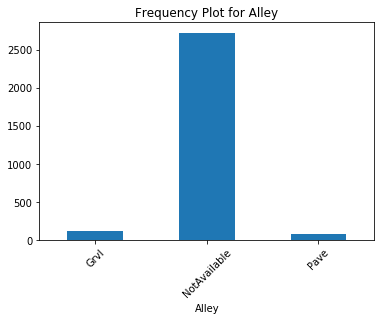

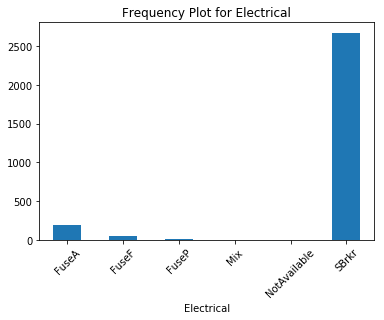

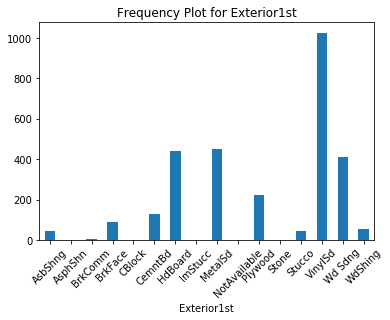

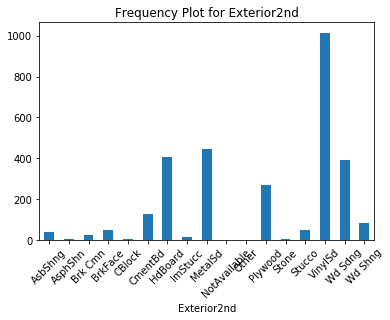

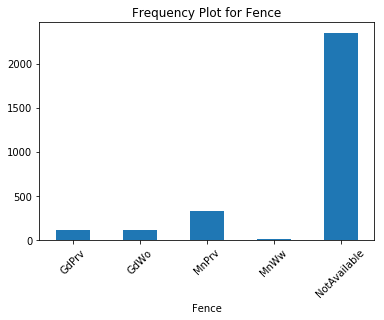

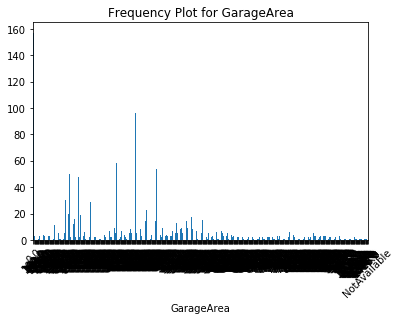

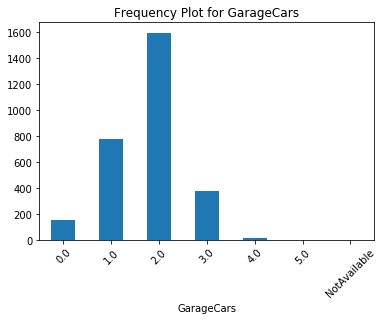

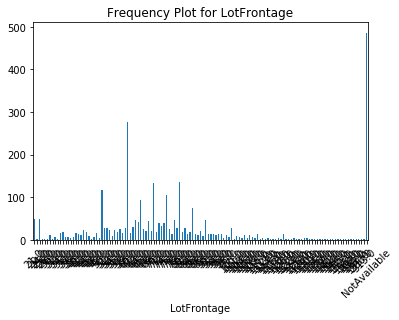

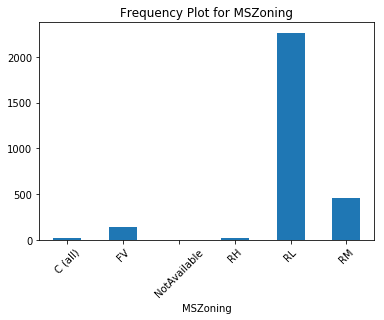

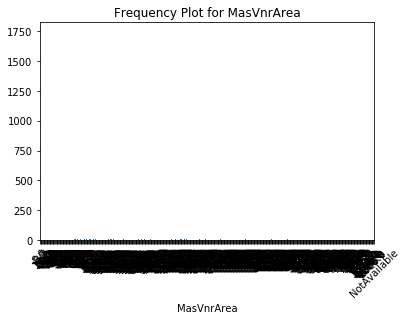

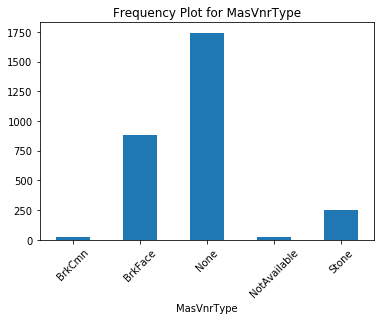

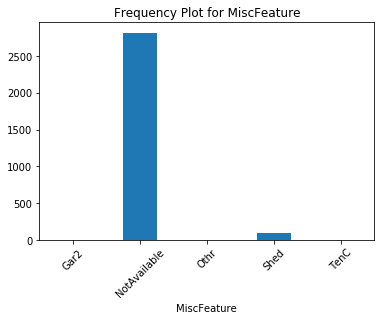

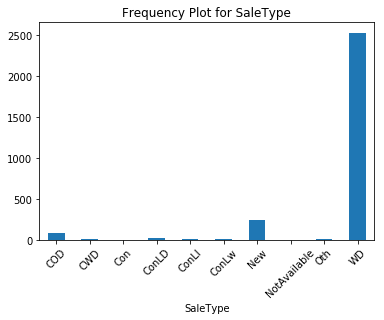

In [136]:
def plotNAs(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    #nan_columns.remove('SalePrice')
    for c in df.fillna('NotAvailable')[nan_columns]:
        df[[c,'SalePrice']].fillna('NotAvailable').\
        groupby(by=c).agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+c)
        plt.xticks(rotation=45)
        plt.show()
plotNAs(df_stage_1.copy())

### 1. Alley

Initial Shape :  (2919, 78)


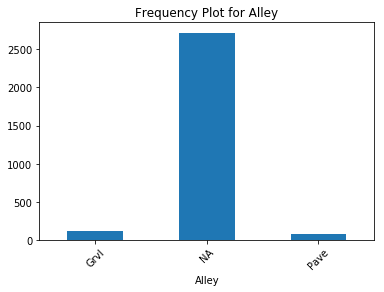

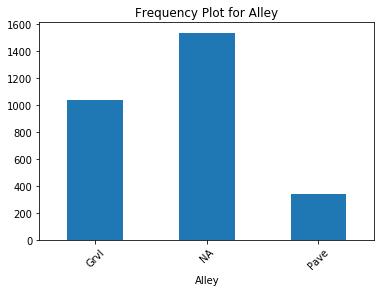

Alley Snapshot Before : NA - 2721 Grvl -  120 Pave -  78
Alley Snapshot After  : NA - 1538 Grvl -  1041 Pave -  340


In [137]:
def outerLandScape(df_temp):
    df = df_temp.copy()
    print("Initial Shape : ", df.shape)
    
    beyond_house = ['Neighborhood','Street', 'PavedDrive', 'Alley']
    df_temp = df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'PavedDrive', 'Alley',"SalePrice"]]
    dd()
    
    def getAlley(Street, Neighborhood, PavedDrive):
        try:
            alley = df_temp[
                (df_temp['Street'] == Street ) &
                (df_temp['Neighborhood'] == Neighborhood ) &
                (df_temp['PavedDrive'] == PavedDrive) 
            ]['Alley'].tolist()[0]
        except:
            alley = 'NA'
        
        return alley
        
    
    df['Alley'] = df.Alley.fillna("NA")
    df[['Alley','SalePrice']].fillna(0).\
        groupby(by='Alley').agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+'Alley')
    plt.xticks(rotation=45)
    plt.show()
    
    na_alley_count = df[df.Alley == "NA"].shape[0]
    gr_alley_count = df[df.Alley == "Grvl"].shape[0]
    pa_alley_count = df[df.Alley == "Pave"].shape[0]
    
        
    df['Alley'] = df.apply( lambda x: getAlley (x['Street']
                                                ,x['Neighborhood']
                                                ,x['PavedDrive']
                                               ) if x['Alley'] == "NA" else x['Alley']
        ,axis=1)
    
    
    df[['Alley','SalePrice']].fillna(0).\
        groupby(by='Alley').agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+'Alley')
    plt.xticks(rotation=45)
    plt.show()
    
    
    print("Alley Snapshot Before : NA -", na_alley_count,"Grvl - ", gr_alley_count, "Pave - ", pa_alley_count)
    print("Alley Snapshot After  : NA -", df[df.Alley == "NA"].shape[0],
          "Grvl - ", df[df.Alley == "Grvl"].shape[0], "Pave - ", df[df.Alley == "Pave"].shape[0]
         )
    
    return df

df_alley = outerLandScape(df_stage_1)

In [138]:
def outerLandScape2():
    df_train = pd.read_csv(train_File)
    df_test = pd.read_csv(test_File)
    
    df = pd.concat([df_train, df_test], axis=0,sort=True,ignore_index=True)
    print("Initial Shape : ", df.shape)
    
    '''beyond_house = [ 'MSZoning','Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'PavedDrive','SaleCondition','Fence', 'Alley']
    df_temp = df[beyond_house].copy()
    for c in beyond_house:
        df_temp = df_temp[df_temp[c].notna()]#.reset_index()
        print(c, df_temp.shape)'''
    #display.display(df_temp)
    
    #beyond_house = ['Neighborhood','Street', 'PavedDrive', 'Alley']
    #df = df.fillna('NNN')
    beyond_house = ['Neighborhood','Street','Alley']
    #beyond_house = ['Street', 'Alley']
    
    #display.display(df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'PavedDrive', 'Alley','Id']])
    display.display(df.groupby(beyond_house).agg('count').reset_index()[['Neighborhood','Street', 'Alley','Id']])
    
    
outerLandScape2()

Initial Shape :  (2919, 81)


,Neighborhood,Street,Alley,Id
0,BrkSide,Pave,Pave,8
1,Crawfor,Pave,Grvl,4
2,Edwards,Pave,Grvl,9
3,IDOTRR,Pave,Grvl,15
4,IDOTRR,Pave,Pave,2
5,NAmes,Pave,Grvl,2
6,NAmes,Pave,Pave,1
7,OldTown,Pave,Grvl,89
8,OldTown,Pave,Pave,10
9,SWISU,Pave,Grvl,1


##### We can have the above table mapping missing Alley variable values. I am here assuming that Street and Alley would intersect. Therefore, there is a pattern with respect to location regarding the type of material used.

* However, the variable itself might not have such significance to target variable and hence can we can drop the imputation to it. The model which uses this variable would give lower significance level during training.

### 2. Electrical

In [139]:
def electricalWrangling(df_temp):
    df = df_temp.copy()
    df1 = df_temp.copy()
    print(df[df.Electrical.isna()].shape)
    df['Electrical'] = df.Electrical.fillna('NA')
    display.display(df[['Neighborhood','Electrical', 'SalePrice']].groupby(['Neighborhood','Electrical']).agg('count'))
    
    df1['Electrical'] = df1.Electrical.fillna('SBrkr')
    display.display(df1[['Neighborhood','Electrical', 'SalePrice']].groupby(['Neighborhood','Electrical']).agg('count'))
    return df1
    
df_electrical = electricalWrangling(df_stage_1.drop('Alley',axis=1))

(1, 77)


SalePrice
Neighborhood Electrical           
Blmngtn      SBrkr              28
Blueste      SBrkr              10
BrDale       SBrkr              30
BrkSide      FuseA              23
             FuseF               5
             SBrkr              80
ClearCr      FuseA               2
             FuseF               1
             SBrkr              41
CollgCr      SBrkr             267
Crawfor      FuseA               6
             FuseF               4
             SBrkr              93
Edwards      FuseA              20
             FuseF              15
             FuseP               2
             SBrkr             157
Gilbert      FuseA               1
             SBrkr             164
IDOTRR       FuseA              22
             FuseF               8
             FuseP               2
             Mix                 1
             SBrkr              60
MeadowV      SBrkr              37
Mitchel      FuseA               2
             SBrkr             112
NAmes        FuseA              50
             FuseF               6
             FuseP               1
             SBrkr             386
NPkVill      SBrkr              23
NWAmes       SBrkr             131
NoRidge      SBrkr              71
NridgHt      SBrkr             166
OldTown      FuseA              49
             FuseF               6
             FuseP               3
             SBrkr             181
SWISU        FuseA               5
             FuseF               4
             SBrkr              39
Sawyer       FuseA               5
             FuseF               1
             SBrkr             145
SawyerW      FuseA               2
             SBrkr             123
Somerst      SBrkr             182
StoneBr      SBrkr              51
Timber       FuseA               1
             NA                  1
             SBrkr              70
Veenker      SBrkr              24

SalePrice
Neighborhood Electrical           
Blmngtn      SBrkr              28
Blueste      SBrkr              10
BrDale       SBrkr              30
BrkSide      FuseA              23
             FuseF               5
             SBrkr              80
ClearCr      FuseA               2
             FuseF               1
             SBrkr              41
CollgCr      SBrkr             267
Crawfor      FuseA               6
             FuseF               4
             SBrkr              93
Edwards      FuseA              20
             FuseF              15
             FuseP               2
             SBrkr             157
Gilbert      FuseA               1
             SBrkr             164
IDOTRR       FuseA              22
             FuseF               8
             FuseP               2
             Mix                 1
             SBrkr              60
MeadowV      SBrkr              37
Mitchel      FuseA               2
             SBrkr             112
NAmes        FuseA              50
             FuseF               6
             FuseP               1
             SBrkr             386
NPkVill      SBrkr              23
NWAmes       SBrkr             131
NoRidge      SBrkr              71
NridgHt      SBrkr             166
OldTown      FuseA              49
             FuseF               6
             FuseP               3
             SBrkr             181
SWISU        FuseA               5
             FuseF               4
             SBrkr              39
Sawyer       FuseA               5
             FuseF               1
             SBrkr             145
SawyerW      FuseA               2
             SBrkr             123
Somerst      SBrkr             182
StoneBr      SBrkr              51
Timber       FuseA               1
             SBrkr              71
Veenker      SBrkr              24

##### At Timber, most of them have SBrkr as electrical system. So, it is a safe bet to have the missing entry replaced with 'SBrkr'

### 3. Exterior1st & Exterior2nd

In [140]:
def exteriorWrangle(df_temp):
    df = df_temp.copy()
    dd(df.shape)
    dd(df[df.Exterior1st == df.Exterior2nd].shape)
    dd(df[df.Exterior1st.isna()][['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond', 'MSSubClass']])
    dd(df[df.Exterior2nd.isna()][['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond','MSSubClass']])
    dt = df.\
       groupby(['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond', 'MSSubClass']).\
       agg('count').reset_index().\
       sort_values(by=['MSSubClass','SalePrice'],ascending=False)[['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond','MSSubClass','SalePrice']]
    #dd(dt)
    dd(dt[(dt.MSSubClass == '30') & (dt.Neighborhood == 'Edwards')].head())
    
    def bestExt1(Neighborhood,ExterQual, ExterCond, MSSubClass):
        return dt[(dt.Neighborhood == Neighborhood)&
                  (dt.ExterQual == ExterQual)&
                  (dt.ExterCond ==  ExterCond)&
                  (dt.MSSubClass == MSSubClass)]['Exterior1st'].tolist()[0]
    
    def bestExt2(Neighborhood,ExterQual, ExterCond, MSSubClass):
        return dt[(dt.Neighborhood == Neighborhood)&
                  (dt.ExterQual == ExterQual)&
                  (dt.ExterCond ==  ExterCond)&
                  (dt.MSSubClass == MSSubClass)]['Exterior2nd'].tolist()[0]
        
    df['Exterior1st'] = df.Exterior1st.fillna('NA')
    df['Exterior2nd'] = df.Exterior2nd.fillna('NA')
    
    df['Exterior1st'] = df.apply(lambda x: bestExt1(
                                    x['Neighborhood'], x['ExterQual'], x['ExterCond'], x['MSSubClass']
                                    ) if x['Exterior1st'] =="NA" else x['Exterior1st'], axis=1)
    df['Exterior2nd'] = df.apply(lambda x: bestExt2(
                                    x['Neighborhood'], x['ExterQual'], x['ExterCond'], x['MSSubClass']
                                    ) if x['Exterior2nd'] =="NA" else x['Exterior2nd'], axis=1)
    
    dd(df[df.index == 2151][['Exterior1st','Exterior2nd', 'Neighborhood','ExterQual', 'ExterCond', 'MSSubClass']])
    return df
    

    
df_ext = exteriorWrangle(df_electrical)

(2919, 77)

(2481, 77)

,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass
2151,NaN,NaN,Edwards,3,3,30


,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass
2151,NaN,NaN,Edwards,3,3,30


,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass,SalePrice
827,Wd Sdng,Wd Sdng,Edwards,3,3,30,5
325,MetalSd,MetalSd,Edwards,3,3,30,3
550,Stucco,Stucco,Edwards,3,3,30,2
165,HdBoard,HdBoard,Edwards,3,3,30,1
442,MetalSd,Wd Sdng,Edwards,3,3,30,1


,Exterior1st,Exterior2nd,Neighborhood,ExterQual,ExterCond,MSSubClass
2151,Wd Sdng,Wd Sdng,Edwards,3,3,30


##### it is observed that many of the houses have Exterior1st and Exterior2nd same values per neighborhood. Therefore, we will create a matrix of neighborhood and Exterior1st. We will first populate Exterior1st from neighborhood value and then we will populate Exterior2nd from Exterior1st.

### 4. Fence

In [141]:
def fenceWrangling(df_temp):
    df = df_temp.copy()

    print("Count of missing Fence : ",df[df.Fence.isna()].shape)
    
    df['Fence'] = df.Fence.fillna('NA')
    
    #dd(df.groupby(['MSSubClass', 'Neighborhood','Fence', ]).agg('count').reset_index()[['MSSubClass', 'Neighborhood','Fence', 'SalePrice']])
    dd(df.groupby(['Neighborhood','Fence', ]).agg('count').reset_index()[['Neighborhood','Fence', 'SalePrice']])
    return df
    
df_fence = fenceWrangling(df_ext)

Count of missing Fence :  (2348, 77)


,Neighborhood,Fence,SalePrice
0,Blmngtn,NA,28
1,Blueste,GdPrv,5
2,Blueste,MnPrv,2
3,Blueste,NA,3
4,BrDale,GdPrv,1
5,BrDale,NA,29
6,BrkSide,GdPrv,9
7,BrkSide,GdWo,4
8,BrkSide,MnPrv,19
9,BrkSide,MnWw,1


##### It is too tedious to decide if missing value indicates "NA" - No Fence or the entry was missing. What does actually Fence depend on ?
* For now i m going to rely on NA for the missing entry. Safest assumption.

##### It is too risky to map from othe rvariables. Though it seems like it depends on LotArea or LotFrontage. It is not very clear if it depends solely on one of the variable or sort of combination of others. Let us keep it NA for missing values, so that it would mean no fence available.

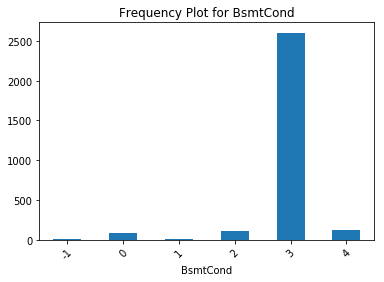

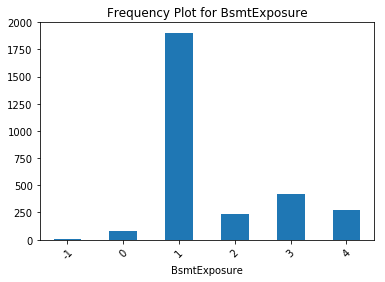

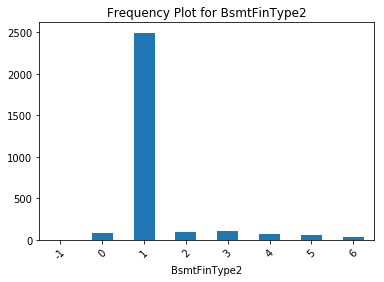

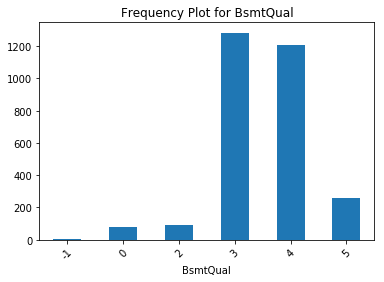

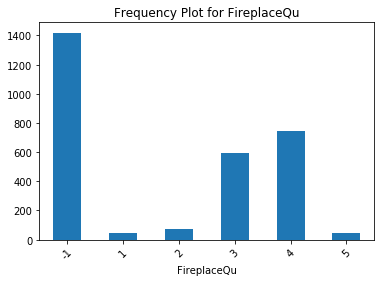

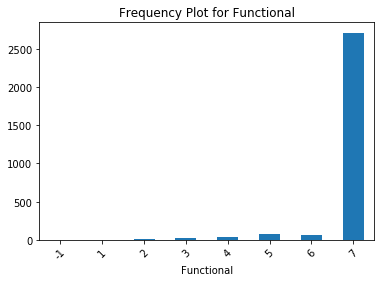

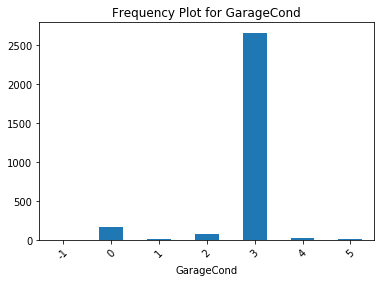

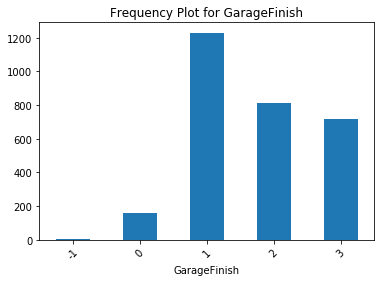

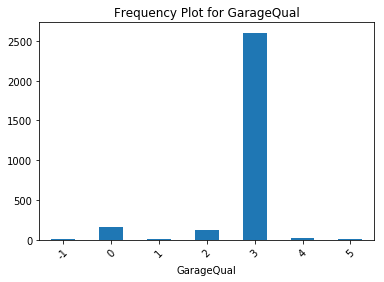

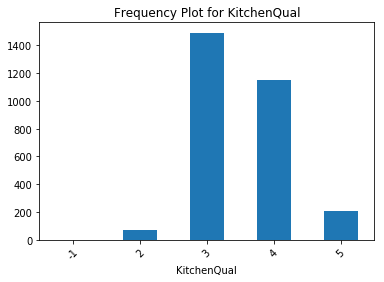

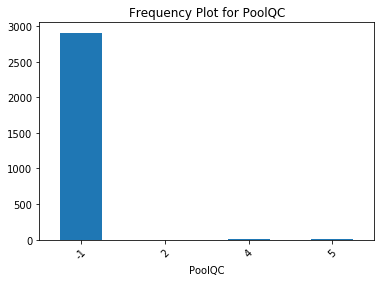

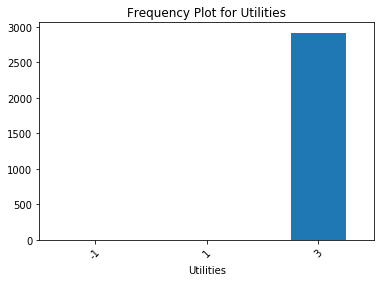

In [142]:
def plotMinusOnes(df):
    minusOneCols = [c for c in list(df) if -1 in df[c].unique()]
    
    for c in df[minusOneCols]:
        df[[c,'SalePrice']].\
        groupby(by=c).agg('count').\
        plot.bar(legend=None, title="Frequency Plot for "+c)
        plt.xticks(rotation=45)
        plt.show()
plotMinusOnes(df_stage_1.copy())

### 5.0 Functional

In [149]:
def functionalWrangle(df):
    print("Unique values in Functional variable Before: ", df.Functional.unique())
    print("How many missing entries are there in Functional variable : ",df[df.Functional == -1].shape[0])
    
    co_qu_columns = [c for c in list(df) if ("Co" in c) or ("Qu" in c)]
    co_qu_columns.append('SalePrice')
    co_qu_columns.append('Functional')
    print("Quality and Condition Related columns : ", co_qu_columns)
    
    dd("Samples with missing functional feature values : " , df[df.Functional.isna()][co_qu_columns])
    
    dd("Let us see the samples which have similar Overall Condition and Quality")
    dd(df[(df.OverallCond == 5) & (df.OverallQual == 1)][co_qu_columns])
    dd(df[(df.OverallCond == 1) & (df.OverallQual == 4)][co_qu_columns])
    
    df.loc[df.Functional == -1, "Functional"] = 7
    
    print("Unique values in Functional variable : ", df.Functional.unique())
    
    return df
    
df_funct = functionalWrangle(df_fence.copy())


Unique values in Functional variable Before:  [ 7  6  3  5  4  2  1 -1]
How many missing entries are there in Functional variable :  2
Quality and Condition Related columns :  ['BsmtCond', 'BsmtQual', 'Condition1', 'Condition2', 'ExterCond', 'ExterQual', 'FireplaceQu', 'GarageCond', 'GarageQual', 'KitchenQual', 'LandContour', 'LotConfig', 'LowQualFinSF', 'OverallCond', 'OverallQual', 'SaleCondition', 'SalePrice', 'Functional']


'Samples with missing functional feature values : '

,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional


'Let us see the samples which have similar Overall Condition and Quality'

,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional
2216,0,0,Norm,Norm,1,2,-1,1,2,2,0,Inside,0.0,5.0,1.0,Abnorml,0.0,-1


,BsmtCond,BsmtQual,Condition1,Condition2,ExterCond,ExterQual,FireplaceQu,GarageCond,GarageQual,KitchenQual,LandContour,LotConfig,LowQualFinSF,OverallCond,OverallQual,SaleCondition,SalePrice,Functional
1558,3,3,Norm,Norm,3,3,-1,0,0,3,1,Inside,0.0,1.0,4.0,Abnorml,0.0,7
2473,2,3,Artery,Norm,2,2,-1,2,3,3,1,Corner,114.0,1.0,4.0,Abnorml,0.0,-1


Unique values in Functional variable :  [7 6 3 5 4 2 1]


##### the rule itself says, assume typical unless deductions are warranted. However, there is no entry of salvage in our data set. Though it is not mandatory to have all categorical values has to be there in the dataset but it always raises the question why not that variable ? Can *Cond and *Qu variable give us hint of not 'Sal' ?

* I am actually tempted to put 'Sal' but due to lack of samples for Sal, I will be putting it as 'Typ'

### 6. LotFrontage

In [163]:
def LotFrontagecheck(df):

    print("Number of samples with missing LotFrontage variable values (Before): ", df[df.LotFrontage.isna()].shape[0])
    df_LotFrontage = df[['Neighborhood','LotFrontage']].groupby('Neighborhood').agg(lambda x:x.value_counts().index[0]).reset_index()
    df_dict = dict([tuple(x) for x in df_LotFrontage.values])
    print("\nLotFrontage median valued per Neighborhood ", df_dict)
    
    df['LotFrontage'] =df.LotFrontage.fillna(-1)
    df['LotFrontage'] =df.apply(lambda x: df_dict[x['Neighborhood']] if x['LotFrontage'] == -1 else x['LotFrontage'],axis=1)
    print("\nNumber of samples with missing LotFrontage variable values (After): ", df[df.LotFrontage.isna()].shape[0])
    

    return df
    
df_lot = LotFrontagecheck(df_funct.copy())

Number of samples with missing LotFrontage variable values (Before):  486

LotFrontage median valued per Neighborhood  {'Blmngtn': 43.0, 'Blueste': 24.0, 'BrDale': 21.0, 'BrkSide': 50.0, 'ClearCr': 80.0, 'CollgCr': 65.0, 'Crawfor': 80.0, 'Edwards': 60.0, 'Gilbert': 59.0, 'IDOTRR': 60.0, 'MeadowV': 21.0, 'Mitchel': 62.0, 'NAmes': 80.0, 'NPkVill': 24.0, 'NWAmes': 80.0, 'NoRidge': 82.0, 'NridgHt': 48.0, 'OldTown': 60.0, 'SWISU': 60.0, 'Sawyer': 70.0, 'SawyerW': 63.0, 'Somerst': 75.0, 'StoneBr': 60.0, 'Timber': 85.0, 'Veenker': 80.0}

Number of samples with missing LotFrontage variable values (After):  0


##### LotFrontage: taking neighborhood as reference most occuring distance is used for filling missing values. Inspiration: neighboring house have same distance to road /gate.

* Lot area > 10000 & LotFrontage > 200  seems like outliers

### 7. MSZoning

In [168]:
def msZoningWrangle(df):
    
    zone_related = ['LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
                    'Condition2', 'BldgType', 'OverallQual', 'OverallCond', 'MSZoning'
                   ]
    
    temp  = df.groupby(['Neighborhood','MSSubClass','MSZoning']).\
    agg('count').reset_index().\
    sort_values(by=['SalePrice'],ascending=False)[['Neighborhood','MSSubClass','MSZoning','SalePrice']]
    dd(temp[(temp.Neighborhood == 'IDOTRR')  |(temp.Neighborhood == 'Mitchel')])
    
    def returnmsZone(Neighborhood,MSSubClass):
        return temp[(temp.Neighborhood == Neighborhood) &
                   (temp.MSSubClass == MSSubClass)]['MSZoning'].tolist()[0]
    
    dd(df[df.MSZoning.isna()][['Neighborhood','MSSubClass','MSZoning']])
    df['MSZoning'] = df.MSZoning.fillna("NA")
    df['MSZoning'] = df.apply(lambda x: returnmsZone(x['Neighborhood'], x['MSSubClass']) 
                              if x['MSZoning'] == "NA" else x['MSZoning'], axis=1)
    
    dd(df[df.index.isin([1915,2216,2250,2904])][['Neighborhood','MSSubClass','MSZoning']])

    return df

df_ms = msZoningWrangle(df_lot.copy())    

,Neighborhood,MSSubClass,MSZoning,SalePrice
88,Mitchel,20,RL,53
75,IDOTRR,50,RM,26
72,IDOTRR,30,RM,21
92,Mitchel,85,RL,13
93,Mitchel,90,RL,12
90,Mitchel,60,RL,11
91,Mitchel,80,RL,10
78,IDOTRR,70,RM,8
74,IDOTRR,50,C (all),7
71,IDOTRR,30,C (all),7


,Neighborhood,MSSubClass,MSZoning
1915,IDOTRR,30,NaN
2216,IDOTRR,20,NaN
2250,IDOTRR,70,NaN
2904,Mitchel,20,NaN


,Neighborhood,MSSubClass,MSZoning
1915,IDOTRR,30,RM
2216,IDOTRR,20,C (all)
2250,IDOTRR,70,RM
2904,Mitchel,20,RL


##### MSZoning is general zoning classification. Therefore,  it must be specific to an area and hence 'Neighborhood' is the variable to our rescue. MSZoning = RL  when neighbor is 'Mitchel' and  RM when neighbor is  IDOTRR and they are is missing.

### 8.0 MasVnrType & MasVnrArea

In [165]:
def MasVnrTypeCheck(df_temp):
    #df = pd.read_csv('train.csv')
    df=df_temp.copy()
    print(df[df.MasVnrType.isna()].shape, )
    #display.display(df[['Neighborhood','MasVnrType','Id']].groupby(['Neighborhood','MasVnrType']).agg('count').reset_index())
    
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrType.isna()].head())
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrArea.isna()].head())
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrArea == 0].head())
    dd(df[['MasVnrType','MasVnrArea']][df.MasVnrType == 'None'].head())
    
    df['MasVnrType'] = df.MasVnrType.fillna("None")
    df['MasVnrArea'] = df.MasVnrArea.fillna(0)

    df['MasVnrArea'] = df['MasVnrArea'].astype(np.float64)

    return df
df_mas = MasVnrTypeCheck(df_ms)

(24, 77)


,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN


,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN


,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


,MasVnrType,MasVnrArea
1,None,0.0
3,None,0.0
5,None,0.0
8,None,0.0
9,None,0.0


* MasVnrArea nan count is equivalent to MasVnrType count.
* MasVnrArea == 0 is already present 
* whenever MasVnrArea == 0 MasVnrType is also None 
* Therefore, MasVnrArea will be mapped to zero when MasVnrType = None

##### Outlier: area > 1400 is only one sample which has low sale price. Its overall condition and quality is moderate and there are enough sample for those bands.

### 9. MiscFeature

In [170]:
def miscFeatureWrangle(df):
    #df = df_temp.copy()
    df_df = df.fillna('NA').groupby(['MiscFeature','MiscVal']).agg('count').reset_index()[['MiscFeature','MiscVal','SalePrice']]
    
    dd("Before :",df_df[df_df.MiscVal == 0])
    dd(df_df[df_df.MiscFeature == "NA"])
    #dd(df_df[df_df.MiscVal == "NA"])
    
    df['MiscFeature'] = df.apply(lambda x: "NA" if x['MiscVal'] == 0 else x['MiscFeature'],axis=1)
    df['MiscFeature'] = df.apply(lambda x: "Gar2" if x['MiscVal'] == 17000.0 else x['MiscFeature'],axis=1)
    
    df_df = df.fillna('NA').groupby(['MiscFeature','MiscVal']).agg('count').reset_index()[['MiscFeature','MiscVal','SalePrice']]
    
    dd("After :",df_df[df_df.MiscVal == 0])
    dd(df_df[df_df.MiscFeature == "NA"])
    return df
    
df_misc = miscFeatureWrangle(df_mas.copy())

'Before :'

,MiscFeature,MiscVal,SalePrice
5,NA,0.0,2813
7,Othr,0.0,1
11,Shed,0.0,2


,MiscFeature,MiscVal,SalePrice
5,NA,0.0,2813
6,NA,17000.0,1


'After :'

,MiscFeature,MiscVal,SalePrice
6,NA,0.0,2816


,MiscFeature,MiscVal,SalePrice
6,NA,0.0,2816


* When MiscVal == 0 ; MiscFeature is mostly NA (None). Note that it can be Shed or Other too. Will park it for next level fine tuning.
* High Values are dedicated to 'Gar2'. Therefore, testing set missing value is gar2 for sure.

### 10. PoolQC

In [180]:
def poolWrangling(df):

    print("Count of Samples which have PoolQC valid values : ", df[df.PoolQC != -1].shape[0] )
    print("Count of missing PoolQC : ",df[df.PoolQC == -1].shape[0])
    
    dd("Pattern of missing PoolQC vs Overall Cond n Qual", df[df.PoolQC == -1][['PoolArea', 'PoolQC','OverallCond','OverallQual']].head())
    dd("Pattern of PoolQC when PoolArea = 0",df[df.PoolArea == 0][['PoolArea', 'PoolQC','OverallCond','OverallQual']]['PoolQC'].unique())
    dd("Dataset samples with PoolArea missing ",df[df.PoolArea.isna()])
    
    dd("PoolQC vs Overall Cond and Qual : " , df.groupby(['OverallCond','OverallQual','PoolQC']).agg('count').reset_index()[['OverallCond','OverallQual','PoolQC','SalePrice']])
    
    df.loc[(df['PoolArea'] == 0) & (df['PoolQC'] == -1), 'PoolQC'] = 0
    df.loc[(df['PoolArea'] > 0) & (df['PoolQC'] == -1), 'PoolQC'] = 2
    
    dd(df[df.PoolQC == -1][['PoolArea', 'PoolQC','OverallCond','OverallQual']])
    dd(Counter(df.PoolQC))
    
    return df
    
df_pool = poolWrangling(df_misc.copy())

Count of Samples which have PoolQC valid values :  10
Count of missing PoolQC :  2909


'Pattern of missing PoolQC vs Overall Cond n Qual'

,PoolArea,PoolQC,OverallCond,OverallQual
0,0.0,-1,5.0,7.0
1,0.0,-1,8.0,6.0
2,0.0,-1,5.0,7.0
3,0.0,-1,5.0,7.0
4,0.0,-1,5.0,8.0


'Pattern of PoolQC when PoolArea = 0'

array([-1], dtype=int64)

'Dataset samples with PoolArea missing '

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,AgeInMonths,AgeWhenSold,AgeWhenRemod


'PoolQC vs Overall Cond and Qual : '

,OverallCond,OverallQual,PoolQC,SalePrice
0,1.0,1.0,-1,1
1,1.0,2.0,-1,1
2,1.0,3.0,-1,1
3,1.0,4.0,-1,2
4,1.0,5.0,-1,2
5,2.0,2.0,-1,2
6,2.0,3.0,-1,2
7,2.0,4.0,-1,1
8,2.0,5.0,-1,3
9,2.0,6.0,-1,1


,PoolArea,PoolQC,OverallCond,OverallQual


Counter({0: 2906, 5: 4, 2: 5, 4: 4})

##### When PoolArea is 0 PoolQC will be NA (no pool). When PoolArea > 0 it appears to be good candidates for "Fa".

* when PoolQC should be "NA" when PoolArea = 0 [Thumb rule / Common sense]
* Missing values have characterstics matching with that of "Fair" condition. It may be "TA" but we dont have enough evidence or rather no evidence for that.

### 11. SaleType

In [181]:
def saleTypeWrangling(df):

    dd(df[df.SaleType.isna()][['MSSubClass', 'MSZoning', 'SaleCondition','SaleType']])
    df1 = df.groupby(['MSSubClass', 'MSZoning', 'SaleCondition','SaleType']).\
    agg('count').reset_index().sort_values('SalePrice',ascending=False)[['MSSubClass', 'MSZoning', 'SaleCondition','SaleType', 'SalePrice']]
    dd(df1[df1.MSSubClass == '20'])
    
    def popSaleType(MSSubClass, MSZoning, SaleCondition):
        return df1[(df1.MSSubClass == MSSubClass) &
                   (df1.MSZoning == MSZoning) &
                   (df1.SaleCondition == SaleCondition)
                  ]['SaleType'].tolist()[0]
    
    df['SaleType'] = df.SaleType.fillna("NA")
    df['SaleType'] = df.apply(lambda x: popSaleType(x['MSSubClass'], x['MSZoning'], x['SaleCondition']) 
                              if x['SaleType'] == "NA" else x['SaleType']
                              ,
                             axis = 1)
    dd(df[df.index == 2489][['MSSubClass', 'MSZoning', 'SaleCondition','SaleType']])
    
    return df
    
df_sale = saleTypeWrangling(df_pool.copy())    

,MSSubClass,MSZoning,SaleCondition,SaleType
2489,20,RL,Normal,NaN


,MSSubClass,MSZoning,SaleCondition,SaleType,SalePrice
63,20,RL,Normal,WD,799
66,20,RL,Partial,New,96
53,20,RL,Abnorml,WD,38
58,20,RL,Normal,COD,23
51,20,RL,Abnorml,COD,23
48,20,FV,Partial,New,19
57,20,RL,Family,WD,15
71,20,RM,Normal,WD,14
47,20,FV,Normal,WD,14
59,20,RL,Normal,CWD,4


,MSSubClass,MSZoning,SaleCondition,SaleType
2489,20,RL,Normal,WD


### 12. Utilities

In [186]:
def utilWrangling(df):
    dd("Missing entries for Utilities : ",df[df.Utilities == -1][['Neighborhood','Utilities']])
    
    df1 = df.groupby(['Neighborhood','Utilities']).agg('count').reset_index().\
    sort_values('SalePrice',ascending=False)[['Neighborhood','Utilities','SalePrice']]
    dd("Relation between Neighborhood and Utilities : ",df1)
    
    def returnUtil(Neighborhood):
        return df1[(df1.Neighborhood == Neighborhood)]["Utilities"].tolist()[0]
    
    
    df['Utilities'] = df.apply(lambda x: returnUtil(x['Neighborhood']) if x['Utilities'] == -1 else x["Utilities"],axis=1)
    
    dd("Post imputation :", df[df.index.isin([1915,1945])][['Neighborhood','Utilities']])
    return df
        
df_util = utilWrangling(df_sale.copy())

'Missing entries for Utilities : '

,Neighborhood,Utilities
1915,IDOTRR,-1
1945,Gilbert,-1


'Relation between Neighborhood and Utilities : '

,Neighborhood,Utilities,SalePrice
14,NAmes,3,443
5,CollgCr,3,267
19,OldTown,3,239
7,Edwards,3,194
23,Somerst,3,182
18,NridgHt,3,166
9,Gilbert,3,164
21,Sawyer,3,151
16,NWAmes,3,131
22,SawyerW,3,125


'Post imputation :'

,Neighborhood,Utilities
1915,IDOTRR,3
1945,Gilbert,3


### 13. KitchenQual

In [193]:
def kitchenQual(df):
    
    dd("Missing samples for KitchenQual", df[df.KitchenQual == -1][['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']])
    
    df1 = df.groupby(['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']).agg('count').\
       reset_index().sort_values('SalePrice', ascending= False)[['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']]
    dd("Kitchen Table : ", df1)
    def returnkqual(OverallCond, OverallQual, KitchenAbvGr):
        return df1[(df1.OverallCond == OverallCond)&
                  (df1.OverallQual == OverallQual) &
                   (df1.KitchenAbvGr == KitchenAbvGr)
                  ]['KitchenQual'].tolist()[0]
    
    df['KitchenQual'] = df.apply(lambda x: returnkqual(x['OverallCond'], x['OverallQual'],x['KitchenAbvGr'])
                                 if x['KitchenQual'] == -1 else x['KitchenQual']
                                ,axis=1)
    dd(df[df.index == 1555][['OverallCond', 'OverallQual', 'KitchenAbvGr', 'KitchenQual']])
    return df

df_kitchen = kitchenQual(df_util.copy())

'Missing samples for KitchenQual'

,OverallCond,OverallQual,KitchenAbvGr,KitchenQual
1555,3.0,5.0,1.0,-1


'Kitchen Table : '

,OverallCond,OverallQual,KitchenAbvGr,KitchenQual
82,5.0,7.0,1.0,4
86,5.0,8.0,1.0,4
69,5.0,5.0,1.0,3
77,5.0,6.0,1.0,3
101,6.0,5.0,1.0,3
78,5.0,6.0,1.0,4
106,6.0,6.0,1.0,3
124,7.0,5.0,1.0,3
89,5.0,9.0,1.0,5
129,7.0,6.0,1.0,3


,OverallCond,OverallQual,KitchenAbvGr,KitchenQual
1555,3.0,5.0,1.0,3


### Checkpoint - 1

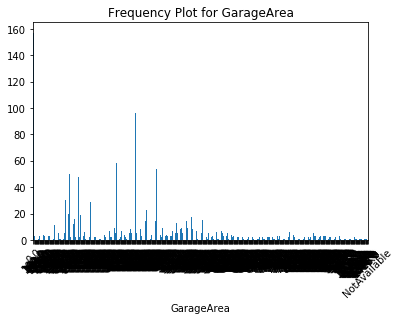

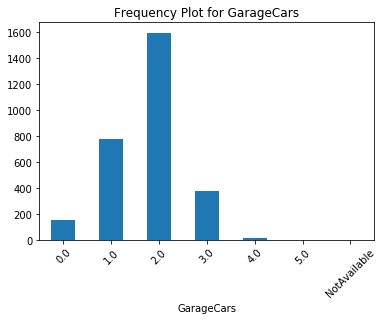

In [194]:
plotNAs(df_kitchen.copy())

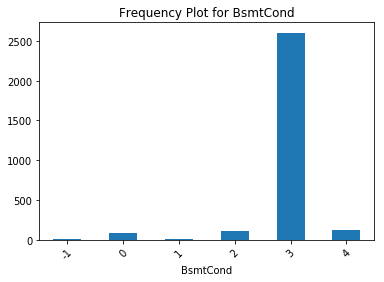

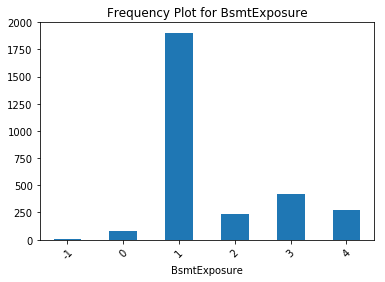

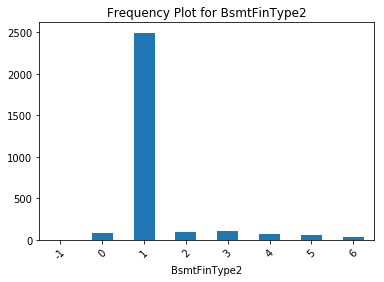

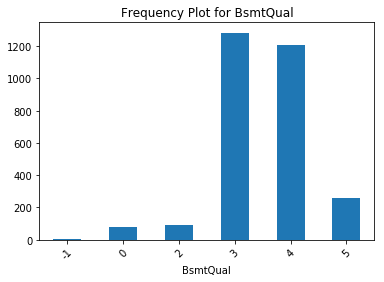

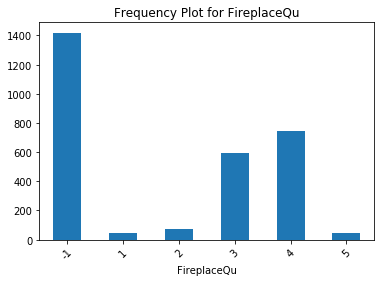

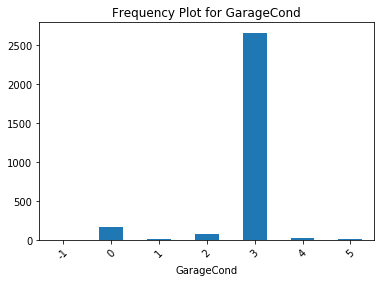

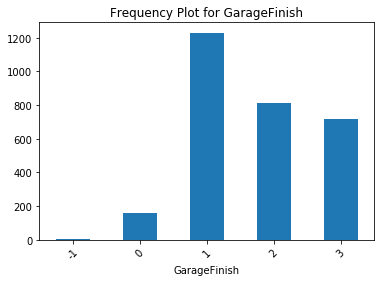

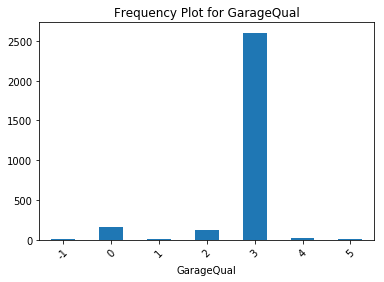

In [195]:
plotMinusOnes(df_kitchen.copy())

In [199]:
def bsmtInterpolate(df):
    bsmt_column = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
    print(bsmt_column)
    
    bsmt_column2 = [c for c in list(df) if 'Bsmt' in c]
    
    dd("BsmtCond missing entries : ", df[df.BsmtCond == -1][bsmt_column])
    bsmt_index = []
    bsmt_index += list(df[df.BsmtCond == -1].index)
    
    dd("BsmtExposure missing entries : ", df[df.BsmtExposure == -1][bsmt_column])
    bsmt_index += list(df[df.BsmtExposure == -1].index)
    
    dd("BsmtFinType1 missing entries :",df[df.BsmtFinType1 == -1][bsmt_column])
    bsmt_index += list(df[df.BsmtFinType1 == -1].index)
    
    dd("BsmtFinType2 missing entries :",df[df.BsmtFinType2 == -1][bsmt_column])
    bsmt_index += list(df[df.BsmtFinType2 == -1].index)
    
    dd("BsmtQual missing entries : ", df[df.BsmtQual == -1][bsmt_column])
    bsmt_index += list(df[df.BsmtQual == -1].index)
    
    df1 = df.groupby(bsmt_column).agg('count').reset_index().sort_values('SalePrice', ascending=False)[(bsmt_column + ['SalePrice'])]
    df1 = df1.sort_values('SalePrice',ascending=False)
    #dd(df1)
    
    def getBsmtCond(BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtCond'].tolist()[0]
    
    def getBsmtExposure(BsmtCond, BsmtFinType1, BsmtFinType2, BsmtQual):
        return df1[(df1.BsmtCond == BsmtCond)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtExposure'].tolist()[0]
    
    def getBsmtFinType1(BsmtExposure, BsmtCond, BsmtFinType2, BsmtQual):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtCond == BsmtCond)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtFinType1'].tolist()[0]
    
    def getBsmtFinType2(BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtCond == BsmtCond)&
                   (df1.BsmtQual == BsmtQual)                   
                  ]['BsmtFinType2'].tolist()[0]
    
    def getBsmtQual(BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtCond):
        return df1[(df1.BsmtExposure == BsmtExposure)&
                   (df1.BsmtFinType1 == BsmtFinType1)&
                   (df1.BsmtFinType2 == BsmtFinType2)&
                   (df1.BsmtCond == BsmtCond)                   
                  ]['BsmtQual'].tolist()[0]
    
    #['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
    df['BsmtCond'] = df.apply(lambda x: getBsmtCond(x['BsmtExposure'], x['BsmtFinType1'], x['BsmtFinType2'], x['BsmtQual'])
                              if x['BsmtCond'] == -1 else x['BsmtCond']
                             , axis = 1)
    
    df['BsmtExposure'] = df.apply(lambda x: getBsmtExposure(x['BsmtCond'], x['BsmtFinType1'], x['BsmtFinType2'], x['BsmtQual'])
                              if x['BsmtExposure'] == -1 else x['BsmtExposure']
                             , axis = 1)
    
    df['BsmtFinType1'] = df.apply(lambda x: getBsmtFinType1(x['BsmtExposure'], x['BsmtCond'], x['BsmtFinType2'], x['BsmtQual'])
                              if x['BsmtFinType1'] == -1 else x['BsmtFinType1']
                             , axis = 1)

    df['BsmtFinType2'] = df.apply(lambda x: getBsmtFinType2(x['BsmtExposure'], x['BsmtFinType1'], x['BsmtCond'], x['BsmtQual'])
                              if x['BsmtFinType2'] == -1 else x['BsmtFinType2']
                             , axis = 1)
    
    df['BsmtQual'] = df.apply(lambda x: getBsmtQual(x['BsmtExposure'], x['BsmtFinType1'], x['BsmtFinType2'], x['BsmtCond'])
                              if x['BsmtQual'] == -1 else x['BsmtQual']
                             , axis = 1)
    
    dd("Post imputation :", df[df.index.isin(bsmt_index)][bsmt_column])
    
    return df
df_bsmt_final = bsmtInterpolate(df_kitchen.copy())


['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']


'BsmtCond missing entries : '

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
2040,-1,2,6,3,4
2185,-1,1,4,1,3
2524,-1,3,5,1,3


'BsmtExposure missing entries : '

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
948,3,-1,1,1,4
1487,3,-1,1,1,4
2348,3,-1,1,1,4


'BsmtFinType1 missing entries :'

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual


'BsmtFinType2 missing entries :'

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
332,3,1,6,-1,4


'BsmtQual missing entries : '

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
2217,2,1,1,1,-1
2218,3,1,1,1,-1


'Post imputation :'

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
332,3,1,6,1,4
948,3,1,1,1,4
1487,3,1,1,1,4
2040,3,2,6,3,4
2185,3,1,4,1,3
2217,2,1,1,1,3
2218,3,1,1,1,3
2348,3,1,1,1,4
2524,3,3,5,1,3


### Garage*

In [205]:
def garageWrangling(df):
    garage_columns = [c for c in df.select_dtypes(exclude=np.number) if "Garage" in c]
    print(garage_columns)
    garage_col2 = [c for c in list(df) if "Garage" in c]
    grp_by = ['GarageType','MiscFeature','OverallQual','OverallCond','GarageFinish','GarageQual','GarageCond',\
              'GarageArea','GarageCars']
    
    new_col = list(set(garage_col2 + grp_by + ['MiscFeature']))
    
    miss_index = []
    for c in garage_col2:
        df_temp = df[df[c] == -1][new_col]
        dd("Missing Entries for "+c+ " : ",df_temp)
        miss_index += list(df_temp.index)
    
    
    df1 = df.groupby(grp_by).agg('count').reset_index().sort_values('SalePrice',ascending=False)[grp_by + ['SalePrice']]
    dd("when garage type == Detchd : ", df1[df1.GarageType == 'Detchd'])
    
    def getGarageArea( GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageArea'].tolist()[0]
    
    def getGarageCars( GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageCars'].tolist()[0]
    
    def getGarageCond(GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageCond'].tolist()[0]
    
    def getGarageFinish(GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageFinish'].tolist()[0]
    
    def getGarageQual(GarageType, MiscFeature, OverallQual, OverallCond):
        return df1[
                   (df1.GarageType == GarageType) &
                   (df1.MiscFeature == MiscFeature) &
                   (df1.OverallQual == OverallQual) &
                   (df1.OverallCond == OverallCond)
                  ]['GarageQual'].tolist()[0]
    
    df['GarageArea'] = df['GarageArea'].fillna("NA")
    df['GarageArea'] = df.apply(lambda x: getGarageArea( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageArea'] =="NA" else x['GarageArea']
                                ,axis =1)
    
    df['GarageCars'] = df['GarageCars'].fillna("NA")
    df['GarageCars'] = df.apply(lambda x: getGarageCars( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageCars'] =="NA" else x['GarageCars']
                                ,axis =1)
    
    df['GarageCond'] = df.apply(lambda x: getGarageCond( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageCond'] == -1 else x['GarageCond']
                                ,axis =1)
    
    df['GarageFinish'] = df.apply(lambda x: getGarageFinish( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageFinish'] == -1 else x['GarageFinish']
                                ,axis =1)
    
    df['GarageQual'] = df.apply(lambda x: getGarageQual( x['GarageType'], x['MiscFeature'], x['OverallQual'], x['OverallCond'])
                                if x['GarageQual'] == -1 else x['GarageQual']
                                ,axis =1)
    
    dd(df[df.index.isin(miss_index)][new_col])
    return df
df_garage_final = garageWrangling(df_bsmt_final.copy())


['GarageType']


'Missing Entries for GarageArea : '

,GarageCond,OverallCond,GarageCars,OverallQual,GarageArea,MiscFeature,GarageFinish,GarageType,GarageQual


'Missing Entries for GarageCars : '

,GarageCond,OverallCond,GarageCars,OverallQual,GarageArea,MiscFeature,GarageFinish,GarageType,GarageQual


'Missing Entries for GarageCond : '

,GarageCond,OverallCond,GarageCars,OverallQual,GarageArea,MiscFeature,GarageFinish,GarageType,GarageQual
2126,-1,8.0,1.0,6.0,360.0,Shed,-1,Detchd,-1
2576,-1,6.0,NaN,5.0,NaN,NA,-1,Detchd,-1


'Missing Entries for GarageFinish : '

,GarageCond,OverallCond,GarageCars,OverallQual,GarageArea,MiscFeature,GarageFinish,GarageType,GarageQual
2126,-1,8.0,1.0,6.0,360.0,Shed,-1,Detchd,-1
2576,-1,6.0,NaN,5.0,NaN,NA,-1,Detchd,-1


'Missing Entries for GarageQual : '

,GarageCond,OverallCond,GarageCars,OverallQual,GarageArea,MiscFeature,GarageFinish,GarageType,GarageQual
2126,-1,8.0,1.0,6.0,360.0,Shed,-1,Detchd,-1
2576,-1,6.0,NaN,5.0,NaN,NA,-1,Detchd,-1


'Missing Entries for GarageType : '

,GarageCond,OverallCond,GarageCars,OverallQual,GarageArea,MiscFeature,GarageFinish,GarageType,GarageQual


'when garage type == Detchd : '

,GarageType,MiscFeature,OverallQual,OverallCond,GarageFinish,GarageQual,GarageCond,GarageArea,GarageCars,SalePrice
1982,Detchd,NA,6.0,5.0,1,3,3,440.0,2.0,13
1806,Detchd,NA,5.0,5.0,1,3,3,576.0,2.0,13
1974,Detchd,NA,6.0,5.0,1,3,3,264.0,1.0,11
1914,Detchd,NA,5.0,7.0,1,3,3,576.0,2.0,9
1835,Detchd,NA,5.0,6.0,1,3,3,240.0,1.0,9
1858,Detchd,NA,5.0,6.0,1,3,3,576.0,2.0,9
2111,Detchd,NA,7.0,5.0,2,3,3,480.0,2.0,7
1855,Detchd,NA,5.0,6.0,1,3,3,484.0,2.0,6
1883,Detchd,NA,5.0,7.0,1,3,3,240.0,1.0,6
1841,Detchd,NA,5.0,6.0,1,3,3,308.0,1.0,6


,GarageCond,OverallCond,GarageCars,OverallQual,GarageArea,MiscFeature,GarageFinish,GarageType,GarageQual
2126,3,8.0,1.0,6.0,360.0,Shed,1,Detchd,3
2576,3,6.0,1.0,5.0,240.0,NA,1,Detchd,3


### Checkpoint 2

In [206]:
plotNAs(df_garage_final.copy())

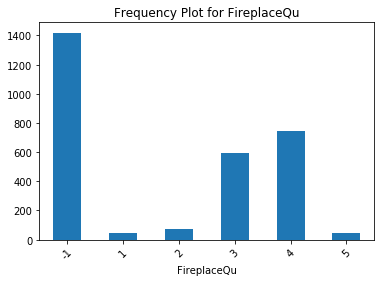

In [207]:
plotMinusOnes(df_garage_final.copy())

In [209]:
did_we_miss_them = ['MSSubClass', 'OverallQual', 'OverallCond', 'FireplaceQu', ]
for c in did_we_miss_them:
    dd(c, df_garage_final[c].unique())

'MSSubClass'

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40', '150'], dtype=object)

'OverallQual'

array([ 7.,  6.,  8.,  5.,  9.,  4., 10.,  3.,  1.,  2.])

'OverallCond'

array([5., 8., 6., 7., 4., 2., 3., 9., 1.])

'FireplaceQu'

array([-1,  3,  4,  2,  5,  1], dtype=int64)

In [212]:
def FireplaceWrangling(df_temp):
    df = pd.read_csv(train_File)
    print("Count of missing FireplaceQu : ",df[df.FireplaceQu.isna()].shape[0])
    dd("Count of Fireplaces == 0",df[['Fireplaces', 'FireplaceQu']][df.Fireplaces == 0].shape)
    dd(df[['Fireplaces', 'FireplaceQu']][df.FireplaceQu.isna()].head())
    dd("When FireplaceQu == NA, Fireplaces:", df[['Fireplaces', 'FireplaceQu']][df.FireplaceQu.isna()]['Fireplaces'].unique())
    dd("When Fireplaces == 0, FireplaceQu:",df[['Fireplaces', 'FireplaceQu']][df.Fireplaces == 0]['FireplaceQu'].unique())
    
    #now we have NA as nan in our wrangled dataset; ideally this should not be problem but let us be consistent.
    df = df_temp.copy()
    
    df['FireplaceQu'] = df.apply(lambda x: 0 if x['Fireplaces'] == 0 else x['FireplaceQu'], axis=1 )
    
    dd("Post imputing :",df.FireplaceQu.unique())
    
    return df
    
df_fire = FireplaceWrangling(df_garage_final.copy())

Count of missing FireplaceQu :  690


'Count of Fireplaces == 0'

(690, 2)

,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN


'When FireplaceQu == NA, Fireplaces:'

array([0], dtype=int64)

'When Fireplaces == 0, FireplaceQu:'

array([nan], dtype=object)

'Post imputing :'

array([0, 3, 4, 2, 5, 1], dtype=int64)

##### FireplaceQu will be mapped to NA (no fireplace) whenever Fireplaces = 0

##### TotalBsmtSF = 0 indicates there is no basement. 
* Therefore, BsmtQual = BsmtCond = BsmtExposure = BsmtFinType1 = BsmtFinType2 = "NA"; when TotalBsmtSF = 0 

* Outlier: (df.BsmtFinSF1 > 2000) & (df.SalePrice < 200000) (2 of them) are outlier because it not only brings the co relation down but also there are enough samples for outlier's overall condition and quality samples.

##### Let us check the datatype if it is corrupted due to our imputate operation

In [213]:
post_imputing_cols = list(df_fire.select_dtypes(include=np.object))
cols_need_change = [c for c in list(df_before_clean.select_dtypes(include=np.number)) if c in post_imputing_cols]

#dd(df_before_clean[df_before_clean.MasVnrArea == 'BrkFace'])

'''for c in post_imputing_cols:
    if c in cols_need_change:
        print(c)
        df_fire[c] = df_fire[c].astype(np.float64)'''
print()

In [214]:
post_imputing_cols = list(df_fire.select_dtypes(include=np.number))
[c for c in list(df_before_clean.select_dtypes(include=np.number)) if c not in post_imputing_cols]

['GarageYrBlt',
 'Id',
 'MSSubClass',
 'MoSold',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold']

In [215]:
post_imputing_cols = list(df_fire.select_dtypes(include=np.object))
[c for c in list(df_before_clean.select_dtypes(include=np.object)) if c not in post_imputing_cols]

['Alley',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'ExterCond',
 'ExterQual',
 'FireplaceQu',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotShape',
 'PavedDrive',
 'PoolQC',
 'Utilities']

In [220]:
post_imputing_cols = list(df_fire.select_dtypes(include=np.number))

_= [dd(c,df_fire[c].unique()) for c in list(df_fire.select_dtypes(exclude=np.number))]

'CentralAir'

array(['Y', 'N'], dtype=object)

'Condition1'

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

'Condition2'

array(['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
      dtype=object)

'Electrical'

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

'Exterior1st'

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

'Exterior2nd'

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

'Fence'

array(['NA', 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

'Foundation'

array(['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], dtype=object)

'GarageType'

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'NA', 'Basment',
       '2Types'], dtype=object)

'Heating'

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object)

'LotConfig'

array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object)

'MSSubClass'

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40', '150'], dtype=object)

'MSZoning'

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

'MasVnrType'

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

'MiscFeature'

array(['NA', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

'Neighborhood'

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

'RoofMatl'

array(['CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv',
       'Roll', 'ClyTile'], dtype=object)

'RoofStyle'

array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object)

'SaleCondition'

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

'SaleType'

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'],
      dtype=object)

'Street'

array(['Pave', 'Grvl'], dtype=object)

In [228]:
print("Are there any missing entries for numerical variables ?: ", len([dd(df_fire[c].unique() ) for c in post_imputing_cols if -1 in df_fire[c].unique()]) > 0)

Are there any missing entries for numerical variables ?:  False


### Outliers

In [229]:
print("Shape of the imputed dataset : ", df_fire.shape)
df_out = df_fire[df_fire.SalePrice > 0].copy()
print("Shape of the Outlier Analysis dataset : ", df_out.shape)

Shape of the imputed dataset :  (2919, 77)
Shape of the Outlier Analysis dataset :  (1460, 77)


In [230]:
def computeCorrCols(df):
    df_corr = df.corr()
    
    df1 = df_corr.stack().reset_index().rename(columns={'level_0': "C1", "level_1": "C2", 0 : "Corr_val"})
    
    df1['Corr_val']= df1['Corr_val'].abs()
    df1 = df1[df1['Corr_val'] < 1].sort_values('Corr_val',ascending=False)
    df1 = df1.drop_duplicates('Corr_val').reset_index(drop=True)
    dd(df1)
    
    return df1
df_corr = computeCorrCols(df_out.copy())


,C1,C2,Corr_val
0,AgeWhenSold,AgeInMonths,0.999056
1,GarageQual,GarageCond,0.959172
2,PoolArea,PoolQC,0.937057
3,GarageArea,GarageCars,0.882475
4,FireplaceQu,Fireplaces,0.863241
5,GrLivArea,TotRmsAbvGrd,0.825489
6,1stFlrSF,TotalBsmtSF,0.819530
7,BsmtFinSF2,BsmtFinType2,0.791555
8,SalePrice,OverallQual,0.790982
9,AgeWhenSold,AgeWhenRemod,0.734914


In [231]:
def checkCorr(df_old):
    df = pd.get_dummies(df_old)
    corr_target = []
    df_corr = df.corr()
    for c in list(df_corr):
        corr_target.append((c, np.abs(df_corr.loc[c,'SalePrice'])))

    dd("Top 15 Numerical Variables with High Corr value for SalePrice :",
        [x for x in sorted(corr_target,key=lambda x: x[1], reverse=True) if '_' not in x[0]][1:15])
    
    dd("Top 15 Variables (All Types) with High Corr value for SalePrice :",
        [x for x in sorted(corr_target,key=lambda x: x[1], reverse=True)][1:15])

checkCorr(df_out.copy())

'Top 15 Numerical Variables with High Corr value for SalePrice :'

[('OverallQual', 0.7909816005838047),
 ('GrLivArea', 0.7086244776126511),
 ('ExterQual', 0.6826392416562591),
 ('KitchenQual', 0.6595997207286572),
 ('GarageCars', 0.640409197258349),
 ('GarageArea', 0.6234314389183598),
 ('TotalBsmtSF', 0.6135805515591944),
 ('1stFlrSF', 0.6058521846919166),
 ('BsmtQual', 0.5852071991725148),
 ('FullBath', 0.5606637627484452),
 ('GarageFinish', 0.5492467563332154),
 ('TotRmsAbvGrd', 0.5337231555820238),
 ('AgeWhenSold', 0.5230632371517798),
 ('AgeInMonths', 0.5228973328794962)]

'Top 15 Variables (All Types) with High Corr value for SalePrice :'

[('OverallQual', 0.7909816005838047),
 ('GrLivArea', 0.7086244776126511),
 ('ExterQual', 0.6826392416562591),
 ('KitchenQual', 0.6595997207286572),
 ('GarageCars', 0.640409197258349),
 ('GarageArea', 0.6234314389183598),
 ('TotalBsmtSF', 0.6135805515591944),
 ('1stFlrSF', 0.6058521846919166),
 ('BsmtQual', 0.5852071991725148),
 ('FullBath', 0.5606637627484452),
 ('GarageFinish', 0.5492467563332154),
 ('TotRmsAbvGrd', 0.5337231555820238),
 ('AgeWhenSold', 0.5230632371517798),
 ('AgeInMonths', 0.5228973328794962)]

##### There may be so many outliers but let us target the ones which are not only numerical but also impact the target variables. Let us target top 5 variables for outlier removal. i.e. OverallQual, GrLivArea, ExterQual, KitchenQual, GarageCars & TotalBsmtSF.

* Note that I am not selecte GarageArea for outlier detection following reasons:
   *  it has high co relation with GarageCars
   * GarageCars and GarageArea both gets imputed in our last steps but the error margin is less for GarageCars when compared to GarageArea
   

In [232]:
df_out.GarageCars.unique()

array([2., 3., 1., 0., 4.])

In [234]:
def topCorrWithOthers(df):
    top_5_corr = ['OverallQual', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'TotalBsmtSF']
    print("Co relation of the top 5 columns with others : ")
    for c in top_5_corr:
        dd(c, df_corr[(df_corr.C1 == c) | (df_corr.C2 == c)].head())
        
topCorrWithOthers(df_fire.copy())

Co relation of the top 5 columns with others : 


'OverallQual'

,C1,C2,Corr_val
8,SalePrice,OverallQual,0.790982
11,OverallQual,ExterQual,0.726278
18,OverallQual,KitchenQual,0.673331
24,BsmtQual,OverallQual,0.629379
32,GarageCars,OverallQual,0.600671


'GrLivArea'

,C1,C2,Corr_val
5,GrLivArea,TotRmsAbvGrd,0.825489
13,GrLivArea,SalePrice,0.708624
15,2ndFlrSF,GrLivArea,0.687501
23,GrLivArea,FullBath,0.630012
37,OverallQual,GrLivArea,0.593007


'ExterQual'

,C1,C2,Corr_val
11,OverallQual,ExterQual,0.726278
12,KitchenQual,ExterQual,0.716122
16,SalePrice,ExterQual,0.682639
33,ExterQual,AgeInMonths,0.598160
34,ExterQual,AgeWhenSold,0.597271


'KitchenQual'

,C1,C2,Corr_val
12,KitchenQual,ExterQual,0.716122
18,OverallQual,KitchenQual,0.673331
19,KitchenQual,SalePrice,0.659600
61,KitchenQual,AgeInMonths,0.530165
62,KitchenQual,AgeWhenSold,0.528921


'GarageCars'

,C1,C2,Corr_val
3,GarageArea,GarageCars,0.882475
21,GarageCars,SalePrice,0.640409
32,GarageCars,OverallQual,0.600671
40,GarageFinish,GarageCars,0.579729
41,GarageQual,GarageCars,0.576622


'TotalBsmtSF'

,C1,C2,Corr_val
6,1stFlrSF,TotalBsmtSF,0.819530
27,SalePrice,TotalBsmtSF,0.613581
47,TotalBsmtSF,BsmtQual,0.564299
59,TotalBsmtSF,OverallQual,0.537808
67,BsmtFinSF1,TotalBsmtSF,0.522396


In [235]:
#df_out['SalePrice'] = df_out['SalePrice'] / df_out.GrLivArea

### 1. OverallQual Outlier Check

Co relation before removing the outlier :  0.7909816005838047
Outlier Count:  10
Co relation After removing the outlier :  0.8047020655325039


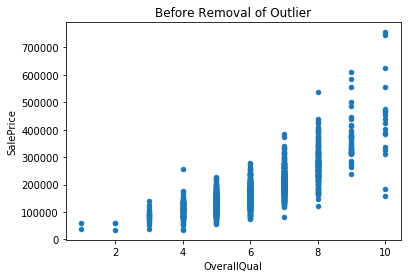

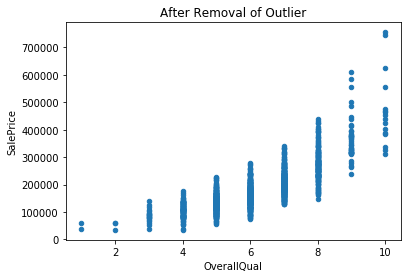

In [273]:
def overallQualOutlier(df):
    df.plot.scatter("OverallQual", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['OverallQual','SalePrice'])   
    df1 = df[(df.OverallQual != 10) | (df.SalePrice >200000 )]
    df1 = df1[(df1.OverallQual != 4) |  (df1.SalePrice <200000 )]
    df1 = df1[(df1.SalePrice >125000 ) | (df1.OverallQual != 7)]
    df1 = df1[(df1.OverallQual != 8) | (df1.SalePrice >125000 )]
    df1 = df1[(df1.OverallQual != 7) | (df1.SalePrice <360000)]
    df1 = df1[(df1.OverallQual != 8) | (df1.SalePrice < 460000)]
   #.plot.scatter("OverallQual", "SalePrice", title="Zoomed view on a outlier")
    
    print("Outlier Count: ", df.shape[0]-df1.shape[0])
    df1.plot.scatter("OverallQual", "SalePrice", title="After Removal of Outlier")
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['OverallQual','SalePrice'])
    return df1
df_overallqual = overallQualOutlier(df_out.copy())

### 2. GrLivArea Outlier Check

Co relation before removing the outlier :  0.7338417725628318
Outlier Count:  9
Co relation After removing the outlier :  0.7441056165314799


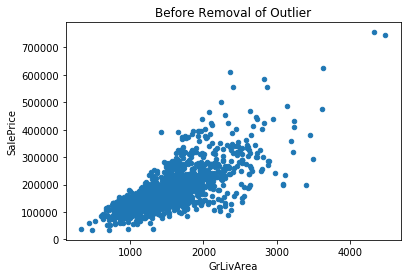

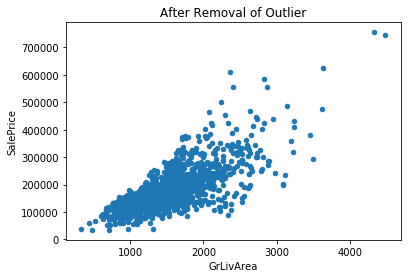

In [274]:
def grLivAreaOutlier(df):
    df.plot.scatter("GrLivArea", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['GrLivArea','SalePrice'])
    df1 = df[(df.GrLivArea < 4000) | (df.SalePrice >250000 )]
    df1 = df1[(df1.GrLivArea > 2000) | (df1.SalePrice < 380000)]
    df1 = df1[(df1.GrLivArea < 3300) | (df1.SalePrice > 220000)]
    print("Outlier Count: ", df.shape[0]-df1.shape[0])
    
    #df1[(df1.GrLivArea > 3000)&(df.SalePrice <300000)].plot.scatter("GrLivArea", "SalePrice", title="Zoomed look on a outlier")
    
    df1.plot.scatter("GrLivArea", "SalePrice", title="After Removal of Outlier")
    
    #dd(corr(df1.GrLivArea, df1.SalePrice))
    
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['GrLivArea','SalePrice'])
    
    return df1
df_liv = grLivAreaOutlier(df_overallqual.copy())

### 2. GarageCars

Co relation before removing the outlier :  0.6400979637148102
Outlier Count :  5
Co relation After removing the outlier :  0.6490938243469744


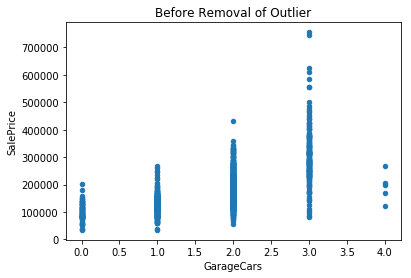

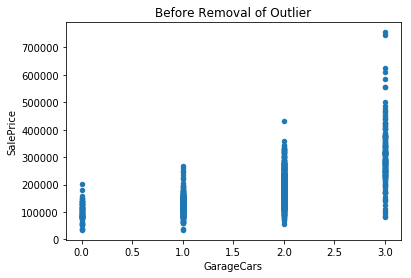

In [275]:
def garageCarsOutlier(df):
    df.plot.scatter("GarageCars", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['GarageCars','SalePrice'])
    
    df1 = df[(df.GarageCars < 4)]
    
    print("Outlier Count : ", df[(df.GarageCars == 4)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['GarageCars','SalePrice'])
    df1.plot.scatter("GarageCars", "SalePrice", title="Before Removal of Outlier")
    return df1
    
df_gar_car = garageCarsOutlier(df_liv.copy())

### 4. ExterQual Outlier Check

In [276]:
def exernalQualOutlier(df):
    df.plot.scatter("ExterQual", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['ExterQual','SalePrice'])
    
    '''df1 = df[(df.GarageArea < 1200) | (df.SalePrice > 300000)]
    
    print("Outlier Count : ", df[(df.GarageArea > 1200) & (df.SalePrice < 300000)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['ExernalQual','SalePrice'])
    df1.plot.scatter("ExernalQual", "SalePrice", title="Before Removal of Outlier")
    
    return df1'''

df_external_qual = exernalQualOutlier(df_gar_car.copy())

KeyError: 'ExernalQual'

### 3.GarageArea

In [ ]:
def garageAreaOutlier(df):
    df.plot.scatter("GarageArea", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['GarageArea','SalePrice'])
    
    df1 = df[(df.GarageArea < 1200) | (df.SalePrice > 300000)]
    
    print("Outlier Count : ", df[(df.GarageArea > 1200) & (df.SalePrice < 300000)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['GarageArea','SalePrice'])
    df1.plot.scatter("GarageArea", "SalePrice", title="Before Removal of Outlier")
    
    return df1

df_gar_area = garageAreaOutlier(df_gar_car.copy())

### 4. TotalBsmtSF

In [ ]:
def totalBsmtSFOutlier(df):
    df.plot.scatter("TotalBsmtSF", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['TotalBsmtSF','SalePrice'])
    df[df.TotalBsmtSF >3000].plot.scatter("TotalBsmtSF", "SalePrice", title="Zoomed look on Outlier")
    df[df.TotalBsmtSF >3100].plot.scatter("TotalBsmtSF", "SalePrice", title="Further Zoomed look on Outlier")
    
    df1 = df[(df.TotalBsmtSF < 3000) | (df.SalePrice > 300000)]
    
    print("Outlier Count : ", df[(df.TotalBsmtSF > 3000) & (df.SalePrice < 300000)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['TotalBsmtSF','SalePrice'])
    df1.plot.scatter("TotalBsmtSF", "SalePrice", title="Before Removal of Outlier")
    
    return df1

df_tot = totalBsmtSFOutlier(df_gar_area.copy())

### 5. 1stFlrSF

In [ ]:
def firststFlrSFOutlierCheck(df):
    df.plot.scatter("1stFlrSF", "SalePrice", title="Before Removal of Outlier")
    df_corr = df.corr()
    print("Co relation before removing the outlier : ",df_corr.loc['1stFlrSF','SalePrice'])
    df[df['1stFlrSF'] >2500].plot.scatter("1stFlrSF", "SalePrice", title="Zoomed look on Outlier")
    #df[df.TotalBsmtSF >3100].plot.scatter("1stFlrSF", "SalePrice", title="Further Zoomed look on Outlier")
    
    df1 = df[(df['1stFlrSF'] < 3000) ]
    
    print("Outlier Count : ", df[(df['1stFlrSF'] > 3000)].shape[0])
    df_corr = df1.corr()
    print("Co relation After removing the outlier : ",df_corr.loc['1stFlrSF','SalePrice'])
    df1.plot.scatter("1stFlrSF", "SalePrice", title="Before Removal of Outlier")
    
    return df1
    
df_1stFlrSF = firststFlrSFOutlierCheck(df_tot.copy())

In [ ]:
checkCorr(df_tot.copy())

In [ ]:
checkCorr(df_1stFlrSF.copy())

#### On comparing the results from the co relation from the above 2 cells, it is clear that we [*should not*] go for the 1stFlrSF outlier removal.

##### Let us check with XGBoost for the score.

list(df_prep)

def getOutlierIndices(df):
    
    print("Shape before removing outlier : ", df.shape)
    '''df = df[(df.GrLivArea < 4000) | (df.SalePrice >250000) | (df.SalePrice == 0) ]
    df = df[(df.GarageCars < 4) | (df.SalePrice == 0)]
    df = df[((df.GarageArea < 1200) | (df.SalePrice > 300000)) | (df.SalePrice ==0)]
    df = df[((df.TotalBsmtSF < 3000) | (df.SalePrice > 300000)) | (df.SalePrice ==0)]'''
    df = df[(df.GrLivArea < 3000)| (df.SalePrice ==0)]
    df = df[(df.SalePrice < 200)| (df.SalePrice ==0)]
    print("Shape after removing outlier : ", df.shape)
    
    return df

df_out_removed = getOutlierIndices(df_fire.copy())

from IPython import display
def transformTarget(df_temp, revert=False ):
    '''df = df_temp.copy()
    #df['new_variable'] = df.BedroomAbvGr * .1 + df.FullBath *.25 + df.HalfBath * .5 + df.BsmtFullBath *.75 + df.BsmtHalfBath * 1
    #df['new_variable'] = df.BedroomAbvGr * .1 + df.FullBath *.25 + df.HalfBath * .5 + df.BsmtFullBath *.75 + df.BsmtHalfBath * .1
    df['new_variable'] = df.BedroomAbvGr.apply(lambda x: x if x > 0 else 1)
    #print("new_variable calculated")
    #display.display(df[df.new_variable.isna()])
    
    if not revert:
        df['sales_per_new'] = df['SalePrice']/ df.new_variable
        #display.display(df[df.sales_per_new.isna()])
        y = np.array(df['sales_per_new'].apply( lambda x: math.log(x)))
        return y
    
    df['sales_per_new'] = df['SalePrice']* df.new_variable
    #print("sales_per_new calculated")
    #display.display(df[df.sales_per_new.isna()])'''
    #return np.log( df_temp.SalePrice / df_temp.GrLivArea)
    return np.log(df_temp['SalePrice'])
    #return (df_temp['SalePrice'])
    

def newBoxCoxTranformation(df_temp,target,testFile=False, log=False):
    df = df_temp.copy()
    #assuming that only numerical features are presented
    if log:
        print("Shape of the dataset initial : ", df.shape)
    
    if not testFile:
        df =df[df.SalePrice >0]
        if log:
            print("Shape of the dataset before transformation : ", df.shape)
        
        #display.display(df[df['SalePrice'].isna()])
        y = transformTarget(df)
        X= df.drop([target],axis = 1)
        #X=df.drop(target, axis=1)
        x_columns = list(X)
        #print(x_columns)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        #X_testx = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X,y)
        #X_testxx = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X,df.SalePrice)
        #print(np.unique(X == X_testx))
        #print(np.unique(X == X_testxx))
        #print(np.unique(X_testx == X_testxx))
        X = pd.DataFrame(X, columns=x_columns)
        
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]
        
        #X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        X = preprocessing.StandardScaler().fit_transform(X)
        #X = X.values
        if log:
            print("Shape of the dataset after transformation : ", X.shape, y.shape)
        return X,y
    else:
        df = df[df.SalePrice == 0.0]
        if log:
            print("Shape of the dataset before transformation : ", df.shape)
        X=df.drop(target,axis = 1)
        x_columns = list(X)
        #print(x_columns)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        
        X = pd.DataFrame(X, columns=x_columns)
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]
        
        
        #X = preprocessing.power_transform( X, method='box-cox')
        #X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        X = preprocessing.StandardScaler().fit_transform(X)
        #X = X.values
        if log:
            print("Shape of the dataset after transformation : ", X.shape)
        return X
        
df_fire_b = df_fire.copy()
df_fire_b['SalePrice'] = df_fire_b['SalePrice'] / df_fire_b.GrLivArea
df_out_removed = getOutlierIndices(df_fire_b.copy())
df_prep = preProcessData(df_out_removed.copy())
X = newBoxCoxTranformation(df_prep.copy(),'SalePrice',True,False)  
X,y = newBoxCoxTranformation(df_prep.copy(),'SalePrice',False,False)

In [ ]:
X_train, X_test, y_traimn, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))

In [ ]:
#reg = XGBRegressor(max_depth=4, n_estimators=200)
'''reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.25,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) #0.13073788936978095'''

'''reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.5, reg_lambda=0.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5) #.144'''
'''reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.35, reg_lambda=0.35, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)#0.13515'''
'''reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.1, reg_lambda=0.6, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) #0.13495'''
'''reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.25,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.1, reg_lambda=0.35, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5) #0.13486'''
'''reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.25, reg_lambda=0.25, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)'''
reg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.25,
       colsample_bytree=0.25, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
       n_jobs=2, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.25, reg_lambda=0.25, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)
reg.fit(X_train,y_train)
reg.score(X_test,y_test)m

#np.sqrt(mean_squared_log_error((y_test), (reg.predict(X_test))))
np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(reg.predict(X_test))))

reg

def dummyCrossValidation(loop_count):
    for i in range(loop_count):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))
        #reg = XGBRegressor(max_depth=3, n_estimators=100, reg_alpha=.5, reg_lambda=.5)
        reg.fit(X_train,y_train)
        
        print("R2 Score: ", reg.score(X_test,y_test))
        #print("RMSLE Score : ", np.sqrt(mean_squared_log_error((y_test), (reg.predict(X_test)))))
        print("RMSLE Score : ", np.sqrt(mean_squared_log_error(np.exp(y_test), np.exp(reg.predict(X_test)))))
dummyCrossValidation(10)

reg.fit(X,y)

def checkTheTrainFile(reg,df_prep):
    df_train = pd.read_csv(train_File)
    #df_tra['SalePrice'] = 0.0
    
    #df_train =  pd.read_csv(train_File)
    #df_concat = pd.concat([df_train,df_test])

    #print(df_test[df_test.TotalBsmtSF.isna()])
    #return
    #df = giveMeWrangledData(df_concat,True)
    
    #print(df.info())
    #df = preProcessData(df)
    #print(df.info())
    #dt = df_prep.copy()
    
    #df_prep = preProcessData(df_fire.copy())
    #dt = dt[dt.SalePrice > 0]
    df_prep1 = df_prep.copy()
    df_prep1 = df_prep1[df_prep1['SalePrice'] > 0]
    df_prep1['New_SalePrice'] = 0.0
    
    df_prep = df_prep[df_prep['SalePrice'] > 0]
    df_prep['SalePrice'] = 0
    
    X = newBoxCoxTranformation(df_prep.copy(),'SalePrice',True)
    #print(np.sqrt(mean_squared_log_error(y, reg.predict(X))))
    
    df_prep1['New_SalePrice'] = list(np.exp(reg.predict(X)))
    #df_prep1['New_SalePrice'] = reg.predict(X)
    df_prep1['New_SalePrice'] = df_prep1['New_SalePrice'] * df_prep1.GrLivArea
    df_prep1['SalePrice'] = df_prep1['SalePrice'] * df_prep1.GrLivArea
    
    
    df_train_score = df_prep1[df_prep1.SalePrice > 0]
    
    print(np.sqrt(mean_squared_log_error(df_train_score['SalePrice'], df_train_score['New_SalePrice'])))
    
    #return df_test, X, reg.predict(X)
#df_test, X_dummy, y_dummy= checkTheTestFile(reg)
checkTheTrainFile(reg,df_prep.copy())

def checkTheTestFile(reg):
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0.0
    print(df_test.shape)
    
    #df_train =  pd.read_csv(train_File)
    #df_concat = pd.concat([df_train,df_test])

    #print(df_test[df_test.TotalBsmtSF.isna()])
    #return
    #df = giveMeWrangledData(df_concat,True)
    
    #print(df.info())
    #df = preProcessData(df)
    #print(df.info())
    X = newBoxCoxTranformation(df_prep.copy(),'SalePrice',True)
    #print(np.sqrt(mean_squared_log_error(y, reg.predict(X))))
    #df_test['SalePrice'] = (reg.predict(X))
    df_test['SalePrice'] = np.exp(reg.predict(X))
    df_test['SalePrice'] = df_test['SalePrice'] * df_test.GrLivArea
    
    return df_test, X, reg.predict(X)
df_test, X_dummy, y_dummy= checkTheTestFile(reg)

In [ ]:
df_test[['Id','SalePrice']].to_csv('smubmission.csv',index=False)

df_test[['Id','SalePrice']]

def forCrossValidationStratifiedShuffleSplit(df):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=.5, random_state=1986)
    #print("Number of Splits configured :", sss.get_n_splits(df, df.BldgType))
    
    for train_index, test_index in sss.split(df, df.BldgType):
        yield train_index, test_index
        
    for train_index, test_index in sss.split(df, df.OverallQual):
        yield train_index, test_index

df_train = pd.read_csv(train_File)
def crossValidationScoring(reg,X,y):
    return -np.sqrt(mean_squared_log_error(np.exp(y), 
                                          np.exp(reg.predict(X))
                                          ))
    #return np.sqrt(mean_squared_log_error(np.exp(y), 
    #                                      np.exp(reg.predict(X
    #                                                        ))
    #                                      ))

    #return np.sqrt(mean_squared_log_error((y), 
    #                                      (reg.predict(X))
    #                                      ))
mean_temp_rmsle = np.mean(cross_val_score(reg,X,y,cv= 5,scoring='neg_mean_squared_log_error'))
print("RMSE with without target variable transformation : ", np.sqrt(mean_temp_rmsle * -1))

mean_temp_rmsle = np.mean(cross_val_score(reg, X, y,
                                          cv= 5,
                                          scoring=crossValidationScoring))
print("RMSE with post target variable transformation : ", mean_temp_rmsle)

from sklearn.model_selection import GridSearchCV
def gridSearchCVImp():
    start_time =datetime.datetime.now()
    #reg = XGBRegressor(n_jobs =2, reg_alpha=.5, reg_lambda=.5, subsample=.5)
    reg = XGBRegressor(n_jobs =2,subsample=.5)
    
    parameters = {
        'max_depth':list(range(3,4)),
        'colsample_bylevel' : np.arange(0.25, 1.0, 0.25),
        'n_estimators' : list(range(300,900,100)),
        'colsample_bytree' : np.arange(0.25, 1.0, 0.25),
        'reg_alpha': np.arange(0.0, 1.0, 0.25),
        'reg_lambda': np.arange(0.25, 1.0, 0.25)
        }
    cv= ShuffleSplit(n_splits=5, test_size=.5, random_state=1986)
    reg_grid = GridSearchCV(reg, parameters, 
                            #cv=forCrossValidationStratifiedShuffleSplit(df_train),
                            cv=cv,
                            n_jobs = 2,
                            #scoring = 'neg_median_absolute_error',
                            #scoring = 'neg_mean_absolute_error',
                            #scoring = 'neg_mean_squared_log_error',
                            #scoring = crossValidationScoring,
                            verbose=1,
                            #error_score ='raise'
                            error_score =5
                            #pre_dispatch = 2
                           )
    reg_grid.fit(X,y)
    
    print("Total time for the gridserach", datetime.datetime.now() - start_time)
    
    return reg_grid
reg_grid = gridSearchCVImp()
print(reg_grid.best_estimator_)
print(reg_grid.best_score_)